In [1]:
import torch
import pandas as pd
import numpy as np
import anndata
from scipy.spatial import distance
import scanpy as sc
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import functools
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm
import scanpy as sc
from collections import Counter
import matplotlib.cm as cm
from anndata import AnnData
import itertools as it
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.sparse import vstack
import time
import torch.nn as nn
import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F
import torch.nn.functional as F

In [2]:
def MARS_loss_tracker (training_history, save):
    
    loss = pd.DataFrame.from_dict(training_history['Loss_tracker'])
    epochs = loss.shape[0]
    
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    
    ax[0].plot(np.arange(epochs), loss['Test_anno'].values, label = "Unannotated landmark loss")
    ax[0].plot(np.arange(epochs), loss['Train_latent_loss'].values, label = "Train latent loss")
    ax[0].plot(np.arange(epochs), loss['Test_latent_loss'].values, label = "Test latent loss")
    ax[0].set_title("MARS original loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    

    ax[1].plot(np.arange(epochs), loss['Train_reconstr_loss'].values, label = "Train reconstruction loss")
    ax[1].plot(np.arange(epochs), loss['Test_reconstr_loss'].values, label = "Test reconstruction loss")
    ax[1].set_title("Reconstruction loss")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    
    
    fig.suptitle("MARS loss across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()
    
    if save == True:
        fig.savefig("MARS_loss_tracker.png")


def MARS_history(history_train, save):
    
    ###Loss function trajectory
    loss = []
    for l in history_train['Loss']:
        loss.append(l.detach().numpy())
    
    accuracy = history_train['Accuracy']
    
    ##Line plot visuzlie loss per epoch 
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    ax[0].scatter(np.arange(len(loss)),loss)
    ax[0].plot(np.arange(len(loss)),loss)
    ax[0].set_xlabel("Epochs", fontsize=12)
    ax[0].set_ylabel("Training loss", fontsize=12)
    ax[0].set_title("Training loss", fontsize=14)
    
    ax[1].scatter(np.arange(len(accuracy)),accuracy)
    ax[1].plot(np.arange(len(accuracy)),accuracy)
    ax[1].set_xlabel("Epochs", fontsize=12)
    ax[1].set_ylabel("Training accuracy", fontsize=12)
    ax[1].set_title("Training accuracy", fontsize=14)
    
    fig.suptitle("Visualization of MARS metrics across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    
    
    if save == True:
        fig.savefig("MARS_history.png")

    
def MARS_latent_pca(latent_tracker , epoch_num):
    ###Latent space 
    
    train_latent = latent_tracker[epoch_num]['Train_latent'][0].detach().numpy()
    train_label = latent_tracker[epoch_num]['Train_label'][0].detach().numpy()
    
    test_latent = latent_tracker[epoch_num]['Test_latent'][0].detach().numpy()
    test_label = latent_tracker[epoch_num]['Test_label'][0].detach().numpy()
    
    ###Validation PCA visualization 
    
    pca = PCA(n_components=2)
    pca.fit(train_latent)
    pca_df=pd.DataFrame(pca.transform(train_latent))
    pca_df.columns=['PC1','PC2']
    pca_df=pca_df.copy()
    pca_df['dbscan']=train_label
    
    plt.subplots(1, figsize=(10,8))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="dbscan", palette="deep")
    plt.title("Training latent space")
    plt.show()  
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(test_latent)
    pca_df=pd.DataFrame(pca.transform(test_latent))
    pca_df.columns=['PC1','PC2']
    pca_df=pca_df.copy()
    pca_df['dbscan']=test_label
    
    plt.subplots(1, figsize=(10,8))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="dbscan", palette="deep")
    plt.title("Testing latent space")
    plt.show()

    
def MARS_latent_umap(adata,save, plot_gene_list = ['MARS_labels','experiment',
                                              'CST3','CCL5','FCGR3A','NKG7','MS4A1','CD79A','CD8A']  ):
    
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='MARS_embedding')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=plot_gene_list, ncols=2 )

    sub_data = adata[adata.obs['experiment']=='Unannotated',]
    if save == True:
        sc.pl.umap(sub_data, color=plot_gene_list, ncols=2, save = '.png' )
    else: 
        sc.pl.umap(sub_data, color=plot_gene_list, ncols=2 )
        
        
def cell_type_assign(adata, save):

    num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',
              5:'B cell',6:'CAF',7:'Dendritic',8:'Plasma B', 9:'NK'}

    adata.obs['label_name']=adata.obs['truth_labels'].map(num2name)  
    untable = adata.obs.loc[adata.obs['experiment']=='Unannotated',:]
    
    groundtruth_sum = pd.crosstab(untable['truth_labels'], untable['MARS_labels']).sum(axis=1)
    plot = pd.crosstab(untable['truth_labels'], untable['MARS_labels']).div(groundtruth_sum/100, axis=0).plot.bar(figsize=(17,5), width=1)
    plot.set_xticklabels(['Malignant','Endothelial', 'T cell', 'Macrophage', 'B cell',  'CAF', 'Dendritic', 'Plasma B', 'NK' ],
                         rotation = 45)
    plot.legend(title="MARS labels")
    plot.set_xlabel("Ground truth labels", fontsize=18)
    plot.set_title("Distribution of MARS labels and Ground Truths", fontsize=24)
    plot.set_ylabel("% Truth labels in MARS labels", fontsize=18)
    plt.show()
    
    
    if save==True:
        plot.get_figure().savefig("cell_type_groundtruth.png")
    
    groundtruth_sum = pd.crosstab(untable['MARS_labels'], untable['label_name']).sum(axis=1)
    plot = pd.crosstab(untable['MARS_labels'], untable['label_name']).div(groundtruth_sum/100, axis=0).plot.bar(figsize=(17,5), width=1)
    plot.legend(title="Ground truth")
    plot.set_xlabel("MARS labels", fontsize=18)
    plot.set_ylabel("% MARS labels in Truth labels", fontsize=18)
    plt.show()
    
    if save==True:
        plot.get_figure().savefig("cell_type_MARS.png")

        
def MARS_silhouette(adata, save):
    
    
    anno_data = adata[adata.obs['experiment'] == "Annotated", :]
    unanno_data = adata[adata.obs['experiment'] == "Unannotated", :]
    
    anno_obs = anno_data.obs
    unanno_obs = unanno_data.obs
    
    ###Silhouette
    train_latent = anno_data.obsm['MARS_embedding']
    train_sil=silhouette_samples(train_latent, anno_obs['truth_labels'].values)
    
    val_latent = unanno_data.obsm['MARS_embedding']
    val_sil=silhouette_samples(val_latent, unanno_obs['truth_labels'].values)
    
    n_clusters=len(Counter(adata.obs['truth_labels'].values).keys())
    
    ###Plot silhouette score for train and test 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 10)
        
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(train_latent) + (n_clusters + 1) * 10])
    
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(val_latent) + (n_clusters + 1) * 10])
         
    y_lower = 10
    val_y_lower = 10
    
    
    name2num={'Malignant':1, 'Endothelial':2, 'T cell':3, 
          'Macrophage':4, 'B cell':5,'CAF':6, 
          'Dendritic':7 ,'Plasma B':8, 'NK':9}

    cluster_list = list(name2num.keys())
    
    for i in range(n_clusters):
        
        
        #cluster_label = list(Counter(adata.obs['truth_labels']).keys())[i]
        cluster_label = cluster_list[i]
        
        #############################################################
        ###############Training 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        train_ith_cluster_silhouette_values = train_sil[anno_obs['label_name'] == cluster_label]
        train_ith_cluster_silhouette_values.sort()
        
        size_cluster_i = train_ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, train_ith_cluster_silhouette_values) 
        #edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(0.8, y_lower + 0.5 * size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        #############################################################
        ###############Validation 
        val_ith_cluster_silhouette_values = val_sil[unanno_obs['label_name'] == cluster_label]
        val_ith_cluster_silhouette_values.sort()
        
        val_size_cluster_i = val_ith_cluster_silhouette_values.shape[0]
        val_y_upper = val_y_lower + val_size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(val_y_lower, val_y_upper),
                          0, val_ith_cluster_silhouette_values)
        # edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(0.8, val_y_lower + 0.5 * val_size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        val_y_lower = val_y_upper + 10  # 10 for the 0 samples
     
    ax1.set_title("Training silhouette plot for known labels")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax2.set_title("Validation silhouette plot for known labels")
    ax2.set_xlabel("Silhouette coefficient values")
    ax2.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    train_avg=silhouette_score(train_latent, anno_obs['truth_labels'].values)
    val_avg=silhouette_score(val_latent, unanno_obs['truth_labels'].values)
    
    ax1.axvline(x=train_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax2.axvline(x=val_avg, color="red", linestyle="--")
    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle("Silhouette scores for MARS latent space", fontsize=14, fontweight='bold')
    plt.show()  
    
    if save ==True:
        fig.savefig("MARS_silhouette.png")
        
    return train_sil, val_sil, train_avg, val_avg

def MARS_latent_umap_unanno(adata, save, plot_gene_list = ['MARS_labels','experiment',
                                              'CST3','CCL5','FCGR3A','NKG7','MS4A1','CD79A','CD8A']  ):
    
    sub_data = adata[adata.obs['experiment']=='Unannotated',]
    
    sc.pp.neighbors(sub_data, n_neighbors=30, use_rep='MARS_embedding')
    sc.tl.umap(sub_data)

    if save == True:
        sc.pl.umap(sub_data, color=plot_gene_list, ncols=2, save = '.png' )
    else: 
        sc.pl.umap(sub_data, color=plot_gene_list, ncols=2 )

In [3]:
import argparse
import torch.utils.data as data
import numpy as np
import torch

def get_parser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-pretrain_batch', '--pretrain_batch',
                        type=int,
                        help='Batch size for pretraining. Default: no batch',
                        default=None)
    
    parser.add_argument('-pretrain','--pretrain',
                        type = bool,
                        default = True,
                        help='Pretrain model with autoencoder; otherwise load existing')
    
    parser.add_argument('-nepoch', '--epochs',
                        type=int,
                        help='number of epochs to train for',
                        default=30)

    parser.add_argument('-nepoch_pretrain', '--epochs_pretrain',
                        type=int,
                        help='number of epochs to pretrain for',
                        default=25)

    parser.add_argument('-source_file','--model_file',
                        type = str,
                        default = 'trained_models/source.pt',
                        help='location for storing source model and data')

    parser.add_argument('-lr', '--learning_rate',
                        type=float,
                        help='learning rate for the model, default=0.001',
                        default=0.001)

    parser.add_argument('-lrS', '--lr_scheduler_step',
                        type=int,
                        help='StepLR learning rate scheduler step, default=20',
                        default=20) 

    parser.add_argument('-lrG', '--lr_scheduler_gamma',
                        type=float,
                        help='StepLR learning rate scheduler gamma, default=0.5',
                        default=0.5)
  
    parser.add_argument('-seed', '--manual_seed',
                        type=int,
                        help='input for the manual seeds initializations',
                        default=3)
    
    parser.add_argument('--cuda',
                        action='store_true',
                        help='enables cuda')
    
    return parser


'''
Class representing dataset for an single-cell experiment.
'''

IMG_CACHE = {}


class ExperimentDataset(data.Dataset):
    
    
    def __init__(self, x, cells, genes, metadata, y=[]):
        '''
        x: numpy array of gene expressions of cells (rows are cells)
        cells: cell IDs in the order of appearance
        genes: gene IDs in the order of appearance
        metadata: experiment identifier
        y: numeric labels of cells (empty list if unknown)
        '''
        super(ExperimentDataset, self).__init__()
        
        self.nitems = x.shape[0]
        if len(y)>0:
            print("== Dataset: Found %d items " % x.shape[0])
            print("== Dataset: Found %d classes" % len(np.unique(y)))
                
        if type(x)==torch.Tensor:
            self.x = x
        else:
            shape = x.shape[1]
            self.x = [torch.from_numpy(inst).view(shape).float() for inst in x]
        if len(y)==0:
            y = np.zeros(len(self.x), dtype=np.int64)
        self.y = tuple(y.tolist())
        self.xIDs = cells
        self.yIDs = genes
        self.metadata = metadata
            
    def __getitem__(self, idx):
        return self.x[idx].squeeze(), self.y[idx], self.xIDs[idx], self.metadata[idx].squeeze()
    #, self.yIDs[idx]

    def __len__(self):
        return self.nitems
    
    def get_dim(self):
        return self.x[0].shape[0]

class EpochSampler(object):
    '''
    EpochSampler: yield permuted indexes at each epoch.
   
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, indices):
        '''
        Initialize the EpochSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - iterations: number of epochs
        '''
        super(EpochSampler, self).__init__()
        
        self.indices = indices
        

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        
    
        while(True):
            shuffled_idx = self.indices[torch.randperm(len(self.indices))]
            
            yield shuffled_idx
            

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations
    
import torch
from torch.utils.data import DataLoader ##prefetch by batch
#from model.epoch_sampler import EpochSampler


def init_labeled_loader(data, val_split = 0.8):
    """Initialize loaders for train and validation sets. 
    Class labels are used only
    for stratified sampling between train and validation set.
    
    Validation_split = % keeps in training set 
    
    """
    
    target = torch.tensor(list(data.y))
    uniq = torch.unique(target, sorted=True)
    
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    class_idxs = [idx[torch.randperm(len(idx))] for idx in class_idxs]
    
    train_idx = torch.cat([idx[:int(val_split*len(idx))] for idx in class_idxs])
    val_idx = torch.cat([idx[int(val_split*len(idx)):] for idx in class_idxs])
    
    train_loader = DataLoader(data, 
                              batch_sampler=EpochSampler(train_idx),
                              pin_memory=True)
    
    val_loader = DataLoader(data, 
                            batch_sampler=EpochSampler(val_idx),
                            pin_memory=True)
    
    return train_loader, val_loader


def init_loader(datasets, val_split = 0.8):
    
    train_loader_all = []
    val_loader_all = []
    
    for data in datasets:
        
        curr_load_tr, curr_load_val = init_labeled_loader(data, val_split)
        train_loader_all.append(curr_load_tr)
        val_loader_all.append(curr_load_val)
    
    if val_split==1:
        val_loader_all = None
        
    return train_loader_all, val_loader_all


def init_data_loaders(labeled_data, unlabeled_data, 
                      pretrain_data, pretrain_batch, val_split):
    
    """Initialize loaders for pretraing, 
    training (labeled and unlabeled datasets) and validation. """
    
    train_loader, val_loader = init_loader(labeled_data, val_split)
    
    if not pretrain_data:
        pretrain_data = unlabeled_data
    
    pretrain_loader = torch.utils.data.DataLoader(dataset=pretrain_data,
                                                  shuffle=True,
                                                  batch_size=pretrain_batch if pretrain_batch!=None else len(unlabeled_data.x))        
    test_loader = DataLoader(unlabeled_data, 
                            batch_sampler=EpochSampler(torch.randperm(len(unlabeled_data.x))),
                            pin_memory=True) 
    
    #test_loader,_ = init_loader([unlabeled_data], 1.0) # to reproduce results in the paper
    #test_loader = test_loader[0]
    return train_loader, test_loader, pretrain_loader, val_loader
           
           
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment 

def compute_scores(y_true, y_pred, scoring={'accuracy','precision','recall','nmi',
                                                'adj_rand','f1_score','adj_mi'}):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    scores = {}
    y_true, y_pred = hungarian_match(y_true, y_pred)
    set_scores(scores, y_true, y_pred, scoring)
        
    return scores


def set_scores(scores, y_true, y_pred, scoring):
    labels=list(set(y_true))
    
    for metric in scoring:
        if metric=='accuracy':
            scores[metric] = metrics.accuracy_score(y_true, y_pred)
        elif metric=='precision':
            scores[metric] = metrics.precision_score(y_true, y_pred, labels, average='macro')
        elif metric=='recall':
            scores[metric] = metrics.recall_score(y_true, y_pred, labels, average='macro')
        elif metric=='f1_score':
            scores[metric] = metrics.f1_score(y_true, y_pred, labels, average='macro')
        elif metric=='nmi':
            scores[metric] = metrics.normalized_mutual_info_score(y_true, y_pred)
        elif metric=='adj_mi':
            scores[metric] = metrics.adjusted_mutual_info_score(y_true, y_pred)
        elif metric=='adj_rand':
            scores[metric] = metrics.adjusted_rand_score(y_true, y_pred)
                
                
def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    y_true = adjust_range(y_true)
    y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    d = {i:j for i, j in ind}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred


def adjust_range(y):
    """Assures that the range of indices if from 0 to n-1."""
    y = np.array(y, dtype=np.int64)
    val_set = set(y)
    mapping = {val:i for  i,val in enumerate(val_set)}
    y = np.array([mapping[val] for val in y], dtype=np.int64)
    return y


import torch
from torch import nn
from torch.nn import functional as F

class CVAE(nn.Module):
    '''
    '''
    def __init__(self, latent_dim , n_feature , network_architecture , 
                 lambda_reconstruct, lambda_kl , batch_shape=2,
                 p_drop=0.2):
        
        super(CVAE, self).__init__()
        
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.batch_shape = batch_shape
        
        self.encoder = nn.Sequential(
            
            nn.Linear(self.n_feature + self.batch_shape , self.hidden_encode1, bias=True),
            
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_encode1, self.hidden_encode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_encode2, self.hidden_encode3, bias=True),
            nn.ELU(alpha=0.2)
        )
        
        self.mu = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        self.logvar = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        
        self.decoder = nn.Sequential(
            
            nn.Linear(self.latent_dim + self.batch_shape, self.hidden_decode1, bias=True),
            
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_decode1, self.hidden_decode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode2, self.hidden_decode3, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode3, self.n_feature, bias=True)
        )
    
    
    def encode(self, x):
        '''
        Return latent parameters
        '''
        encoded = self.encoder(x)
        
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        
        return [mu, logvar]
        
    
    def decode(self, z):
        '''
        Reconstruct
        '''
        decoded = self.decoder(z)
        return decoded
    
    
    def reparameterize(self, mu , logvar):
        ''' 
        Reparametraization sample N(mu, var) from N(0,1) noise
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) #std represents the size of the tensor
        
        return eps*std + mu                
      
    def forward(self, x, batch_label):
        
        x = torch.cat((x, batch_label), dim=1)
        
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        
        z = torch.cat((z, batch_label), dim=1)
        
        decoded = self.decode(z)
        
        return decoded, mu, logvar
    
def loss_task(encoded, prototypes, target, criterion='dist'):
    """Calculate loss.
    criterion: NNLoss - assign to closest prototype and calculate NNLoss
    dist - loss is distance to prototype that example needs to be assigned to
                and -distance to prototypes from other class
    """
    
    uniq = torch.unique(target, sorted=True)
    
    ###index of samples for each class of labels
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    # prepare targets so they start from 0,1
    for idx,v in enumerate(uniq):
        target[target==v]=idx
    
    dists = euclidean_dist(encoded, prototypes)
    
    if criterion=='NNLoss':
       
        loss = torch.nn.NLLLoss()
        log_p_y = F.log_softmax(-dists, dim=1)
        
        loss_val = loss(log_p_y, target)
        _, y_hat = log_p_y.max(1)
        
    
    elif criterion=='dist':
        
        loss_val = torch.stack([dists[idx_example, idx_proto].mean(0) for idx_proto,idx_example in enumerate(class_idxs)]).mean()
        #loss_val1 = loss_val1/len(embeddings) 
        y_hat = torch.max(-dists,1)[1]
        
    acc_val = y_hat.eq(target.squeeze()).float().mean()    
        
    return loss_val, acc_val

def loss_test_nn(encoded, prototypes):
    
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    print(args_count)
    
    loss = torch.nn.NLLLoss()
    log_p_y = F.log_softmax(-dists, dim=1)
    print(log_p_y.shape)
        
    loss_val = loss(log_p_y, y_hat)
    _, y_hat = log_p_y.max(1)
    
    return loss_val, args_count

###Intra cluster distance
def loss_test_basic(encoded, prototypes):
    
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    #print(args_count)
    
    min_dist = min_dist[0] # get_distances
    
    #thr = torch.stack([torch.sort(min_dist[y_hat==idx_class])[0][int(len(min_dist[y_hat==idx_class])*0.9)] for idx_class in args_uniq])
    #loss_val = torch.stack([min_dist[y_hat==idx_class][min_dist[y_hat==idx_class]>=thr[idx_class]].mean(0) for idx_class in args_uniq]).mean()
    
    loss_val = torch.stack([min_dist[y_hat==idx_class].mean(0) for idx_class in args_uniq]).mean()
    
    #loss_val,_ = loss_task(encoded, prototypes, y_hat, criterion='dist') # same
    
    return loss_val, args_count

##For unannotated set 
def loss_test(encoded, prototypes, tau):
    
    #prototypes = torch.stack(prototypes).squeeze() 
    loss_val_test, args_count = loss_test_basic(encoded, prototypes)
    
    ###inter cluster distance 
    if tau>0:
        dists = euclidean_dist(prototypes, prototypes)
        nproto = prototypes.shape[0]
        loss_val2 = - torch.sum(dists)/(nproto*nproto-nproto)
        loss_val_test += tau*loss_val2
        
    return loss_val_test, args_count

def reconstruction_loss(decoded, x):
    
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    #print('Reconstruction {}'.format(loss_rcn))
    
    return loss_rcn


def vae_loss(model, decoded, x, mu, logvar):
    
#     loss_func = torch.nn.MSELoss()
#     loss_rcn = loss_func(decoded, x)
    #KL =  torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    
    loss_rcn = torch.mean(torch.sum((x - decoded).pow(2),1))
    
    KL_loss = (-0.5)*(1 + logvar - mu.pow(2) - logvar.exp())
    KL = torch.mean(torch.sum(KL_loss, axis=1))
    
    #print(model.lambda_reconstruct, model.lambda_kl)
    total_loss = model.lambda_reconstruct*loss_rcn + model.lambda_kl * KL 
    
    
    #print(f"Reconstruction Loss: {loss_rcn} KL Loss: {KL}")
    
    return total_loss 

import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans

## Training set (annotated landmarks)
def compute_landmarks_tr(embeddings, target, prev_landmarks=None, tau=0.2):
    
    """Computing landmarks of each class in the labeled meta-dataset. 
    
    Landmark is a closed form solution of 
    minimizing distance to the mean and maximizing distance to other landmarks. 
    
    If tau=0, landmarks are just mean of data points.
    
    embeddings: embeddings of the labeled dataset
    target: labels in the labeled dataset
    prev_landmarks: landmarks from previous iteration
    tau: regularizer for inter- and intra-cluster distance
    """
    
    uniq = torch.unique(target, sorted=True)
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    landmarks_mean = torch.stack([embeddings[idx_class].mean(0) for idx_class in class_idxs]).squeeze()
    
    if prev_landmarks is None or tau==0:
        return landmarks_mean
    
    suma = prev_landmarks.sum(0)
    nlndmk = prev_landmarks.shape[0]
    lndmk_dist_part = (tau/(nlndmk-1))*torch.stack([suma-p for p in prev_landmarks])
    landmarks = 1/(1-tau)*(landmarks_mean-lndmk_dist_part)
    
    return landmarks

def init_landmarks(n_clusters, tr_load, test_load,
                   model, device, mode='kmeans', pretrain=True
                   ):
    """Initialization of landmarks of the labeled and unlabeled meta-dataset.
    nclusters: number of expected clusters in the unlabeled meta-dataset
    tr_load: data loader for labeled meta-dataset
    test_load: data loader for unlabeled meta-dataset
    """
    lndmk_tr = [torch.zeros(size=(len(np.unique(dl.dataset.y)), 
                                  model.latent_dim), 
                            requires_grad=True, device=device) for dl in tr_load]
    
    lndmk_test = [torch.zeros(size=(1, model.latent_dim), 
                              requires_grad=True, device=device) 
                       for _ in range(n_clusters)]
    
    kmeans_init_tr = [init_step(dl.dataset, model, device, pretrained=pretrain, mode=mode) 
                      for dl in tr_load]
    
    kmeans_init_test = init_step(test_load.dataset, model, device, 
                                 pretrained=pretrain, mode=mode, 
                                 n_clusters=n_clusters)
    
    ##No gradient calculation
    with torch.no_grad():
        [lndmk.copy_(kmeans_init_tr[idx])  for idx,lndmk in enumerate(lndmk_tr)]
        [lndmk_test[i].copy_(kmeans_init_test[i,:]) for i in range(kmeans_init_test.shape[0])]
        
    return lndmk_tr, lndmk_test


def init_step(dataset, model, device, pretrained, mode='kmeans',n_clusters=None):
    """Initialization of landmarks with k-means or k-means++ given dataset."""
    
    if n_clusters==None:
        n_clusters = len(np.unique(dataset.y))
    
    nexamples = len(dataset.x)
        
    X =  torch.stack([dataset.x[i] for i in range(nexamples)])
    batch_label = torch.stack([dataset.metadata[i] for i in range(nexamples)])
    
    
    if mode=='kmeans++':
        if not pretrained: # find centroids in original space
            landmarks = k_means_._init_centroids(X.cpu().numpy(), n_clusters, 'k-means++')
            landmarks = torch.tensor(landmarks, device=device)
            landmarks = landmarks.to(device)
            lndmk_encoded,_ = model(landmarks)
            
        else:
            X = X.to(device)
            encoded,_ = model(X)
            landmarks = k_means_._init_centroids(encoded.data.cpu().numpy(), n_clusters, 'k-means++')
            lndmk_encoded = torch.tensor(landmarks, device=device)
    
    elif mode=='kmeans': # run kmeans clustering
        if not pretrained: 
            kmeans = KMeans(n_clusters, random_state=0).fit(X.cpu().numpy())
            landmarks = torch.tensor(kmeans.cluster_centers_, device=device)
            landmarks = landmarks.to(device)
            ##Feed forward net on landmarks  (k means cluster)
            ##landmarks are k means cluster centers = coordinates of cluster center
            #lndmk_encoded,_ = model(landmarks)
            _ , lndmk_encoded, _ = model(landmarks)
        
        ##cluster on lower embedding space
        else:
            X = X.to(device)
            #encoded,_ = model(X)
            decode , encoded, logvar = model(X, batch_label)
            kmeans = KMeans(n_clusters, random_state=0).fit(encoded.data.cpu().numpy())
            lndmk_encoded = torch.tensor(kmeans.cluster_centers_, device=device)
    
    return lndmk_encoded

class CVAE_MARS:
    def __init__(self, n_clusters, params, 
                 labeled_data, unlabeled_data, 
                 pretrain_data=None, 
                 
                 val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2,
                 
                 latent_dim = 50, 
                 n_feature = 10, 
                 
                 network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                 
                 lambda_reconstruct = 1e-4, lambda_kl = 1e-3, batch_shape = 2
                ):
        
        """Initialization of MARS.
        n_clusters: number of clusters in the unlabeled meta-dataset
        params: parameters of the MARS model
        labeled_data: list of labeled datasets. Each dataset needs to be instance of CellDataset.
        unlabeled_data: unlabeled dataset. Instance of CellDataset.
        pretrain_data: dataset for pretraining MARS. Instance of CellDataset. If not specified, unlabeled_data
                        will be used.
        val_split: percentage of data to use for train/val split (default: 1, meaning no validation set)
        hid_dim_1: dimension in the first layer of the network (default: 1000)
        hid_dim_2: dimension in the second layer of the network (default: 100)
        p_drop: dropout probability (default: 0)
        tau: regularizer for inter-cluster distance
        """
        train_load, test_load, pretrain_load, val_load = init_data_loaders(labeled_data, unlabeled_data, 
                                                                           pretrain_data, params.pretrain_batch, 
                                                                           val_split)
        self.train_loader = train_load
        self.test_loader = test_load
        self.pretrain_loader = pretrain_load
        self.val_loader = val_load
        
        ##data file type (string name)
#         self.labeled_metadata = [data.metadata for data in labeled_data]
#         self.unlabeled_metadata = unlabeled_data.metadata
        
    
        meta_label = ["Annotated"+str(i)for i in range(batch_shape-1)]
        self.labeled_metadata = meta_label
        
        self.unlabeled_metadata = "Unannotated"
        
        self.genes = unlabeled_data.yIDs
        
        ##number of genes 
        x_dim = self.test_loader.dataset.get_dim()
        
        ##KNN clusters
        self.n_clusters = n_clusters
        
        ##General Parameters
        self.device = params.device
        self.epochs = params.epochs
        self.epochs_pretrain = params.epochs_pretrain
        self.pretrain_flag = params.pretrain
        self.model_file = params.model_file
        self.lr = params.learning_rate
        self.lr_gamma = params.lr_scheduler_gamma
        self.step_size = params.lr_scheduler_step
        
        self.tau = tau
        
        ##VAE parameter
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
#         self.hidden_encode1=network_architecture['n_hidden_recog_1']
#         self.hidden_encode2=network_architecture['n_hidden_recog_2']
#         self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
#         self.hidden_decode1=network_architecture['n_hidden_gener_1']
#         self.hidden_decode2=network_architecture['n_hidden_gener_2']
#         self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.batch_shape = batch_shape
        
        self.init_model(self.latent_dim, self.n_feature, network_architecture, 
                        self.lambda_reconstruct, self.lambda_kl, params.device, self.batch_shape)
        
        #print(self.lambda_reconstruct)
        
    ###################################################################
    ###################################################################    
    ###### With the fine tuned hyper parameter     
    ###### Change the implementation of AE to VAE     
    def init_model(self, 
                   latent_dim , 
                   n_feature, 
                   network_architecture, 
                   lambda_reconstruct, lambda_kl,
                   device, batch_shape
                  ):
        """
        Initialize the model.
        """
        #self.model = FullNet(x_dim, hid_dim, z_dim, p_drop).to(device)
        self.model = CVAE(latent_dim = latent_dim, 
                         n_feature = n_feature, 
                         network_architecture= network_architecture,
                         lambda_reconstruct = lambda_reconstruct, 
                         lambda_kl = lambda_kl,
                         batch_shape = batch_shape
                        ).to(device)
        
        
    ###################################################################
    ###################################################################
    
    def init_optim(self, param1, param2, learning_rate):
        """Initializing optimizers."""
        
        optim = torch.optim.Adam(params=param1, lr=learning_rate)
        optim_landmk_test = torch.optim.Adam(params=param2, lr=learning_rate)
        
        return optim, optim_landmk_test
    
    ###################################################################
    ###################################################################
    ########VAE (KL + reconstruction loss + regularized)
    def pretrain(self, optim):
        """
        Pretraining model with variational autoencoder.
        only on unannotated dataset 
        optim: optimizer
        """
        print('Pretraining..')
        
        pretrain_loss =[]
        
        for e in range(self.epochs_pretrain):
            
            start = time.time()
            
            
            for _, batch in enumerate(self.pretrain_loader):
                
                x, y, cell_name, batch_label = batch
                
                x = x.to(self.device)
                batch_label = batch_label.to(self.device)
                
#                 print(batch_label.shape)
#                 print(x.shape)
                
                #_, decoded = self.model(x)
                decoded, mu, logvar = self.model(x , batch_label )
                
                #loss = reconstruction_loss(decoded, x) 
                loss = vae_loss(self.model, decoded, x, mu, logvar)
                
                optim.zero_grad()              
                loss.backward()                    
                optim.step() 
                
                
            pretrain_loss.append(loss) 
            
            print(f"Pretraining Epoch {e}, Loss: {loss}")
            print("Time: ", time.time()-start)
        
        print("Pretraining done")
        return mu, pretrain_loss
    ###################################################################
    ###################################################################
    
    
    def train(self, evaluation_mode=True, save_all_embeddings=True):
        """Train model.
        evaluation_mode: if True, validates model on the unlabeled dataset. 
        In the evaluation mode, ground truth labels of the unlabeled dataset must be 
        provided to validate model
        
        save_all_embeddings: if True, MARS embeddings for annotated and unannotated 
        experiments will be saved in an anndata object,
        otherwise only unnanotated will be saved. 
        If naming is called after, all embeddings need to be saved
        
        return: adata: anndata object containing labeled and unlabeled meta-dataset 
        with MARS embeddings and estimated labels on the unlabeled dataset
                landmk_all: landmarks of the labeled and unlabeled meta-dataset in the 
                order given for training. Landmarks on the unlabeled
                            dataset are provided last
                metrics: clustering metrics if evaluation_mode is True
                
        """
        tr_iter = [iter(dl) for dl in self.train_loader]
        
        if self.val_loader is not None:
            val_iter = [iter(dl) for dl in self.val_loader]
        
        ##############################
        ####Pre train step 
        ##############################
        optim_pretrain = torch.optim.Adam(params=list(self.model.parameters()), lr=self.lr)
        
        if self.pretrain_flag:
            pretrain_latent , pretrain_loss = self.pretrain(optim_pretrain)
        else:
            self.model.load_state_dict(torch.load(self.MODEL_FILE))    
        ##############################
        
        
        test_iter = iter(self.test_loader)
        
        
        ##initialize training (annotated landmark) and testing (unannotated landmark)
        landmk_tr, landmk_test = init_landmarks(self.n_clusters, 
                                                self.train_loader, 
                                                self.test_loader, 
                                                self.model, self.device)
        
        optim, optim_landmk_test = self.init_optim(list(self.model.encoder.parameters()), 
                                                   landmk_test, self.lr)
        
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                       gamma=self.lr_gamma,
                                                       step_size=self.step_size)
        
        latent_tracker = []
        training_history = {'Loss':[],'Accuracy':[],'Loss_tracker':[]}
        best_acc = 0
        
        for epoch in range(1, self.epochs+1):
            
            start = time.time()
            
            #########################
            #####   Model training 
            #########################
            self.model.train()
            
            ##Do_epoch train over each minibatch return
            ##training loss, accuracy, updated landmarks (annoated and unannotated)
            ##latent_history returns latents space for 1) training 2) testing 3) training landmark 4) testing landmark
            loss_tr, acc_tr, landmk_tr, landmk_test, latent_history, loss_tracker = self.do_epoch(tr_iter, test_iter,
                                                                                    optim, 
                                                                                    optim_landmk_test,
                                                                                    landmk_tr, 
                                                                                    landmk_test)
            
            ##Loss training includes 1 - VAE loss 2- embedding and landmark distance 
            print(f'Epoch {epoch} Loss training: {loss_tr}, Accuracy training: {acc_tr}')
            
            print("Time: ", time.time()-start)
        
            ###Track model training 
            training_history['Loss'].append(loss_tr)
            training_history['Accuracy'].append(acc_tr)
            training_history['Loss_tracker'].append(loss_tracker)
            latent_tracker.append(latent_history)
            
            ##only print out the last epoch result indicating end of training
            if epoch==self.epochs: 
                print('\n=== Epoch: {} ==='.format(epoch))
                print('Train acc: {}'.format(acc_tr))
            
            if self.val_loader is None:
                continue
            
            #########################
            #####   Model evaluation 
            #########################
            self.model.eval()
            
            with torch.no_grad():
                
                loss_val, acc_val = self.do_val_epoch(val_iter, landmk_tr)
                
                if acc_val > best_acc:
                    print('Saving model...')
                    best_acc = acc_val
                    best_state = self.model.state_dict()
                    #torch.save(model.state_dict(), self.model_file)
                postfix = ' (Best)' if acc_val >= best_acc else ' (Best: {})'.format(best_acc)
                print('Val loss: {}, acc: {}{}'.format(loss_val, acc_val, postfix))
            lr_scheduler.step()
            
           
            
            
        if self.val_loader is None:
            best_state = self.model.state_dict() # best is last
        
        landmk_all = landmk_tr + [torch.stack(landmk_test).squeeze()]
        
        ##Test time (assign labels to unlabaled data)
        adata_test, eval_results = self.assign_labels(landmk_all[-1], evaluation_mode)
        
        adata = self.save_result(tr_iter, adata_test, save_all_embeddings)
        
        if evaluation_mode:
            return adata, landmk_all, eval_results, training_history, latent_tracker, pretrain_latent , pretrain_loss
        
        return adata, landmk_all, training_history, latent_tracker, pretrain_latent , pretrain_loss
    
    def save_result(self, tr_iter, adata_test, save_all_embeddings):
        """Saving embeddings from labeled and unlabeled dataset, ground truth labels and 
        predictions to joint anndata object."""
        
        adata_all = []

        if save_all_embeddings:
            for task in range(len(tr_iter)): # saving embeddings from labeled dataset
                
                task = int(task)
                
                x, y, cells, batch_label = next(tr_iter[task])
                x, y = x.to(self.device), y.to(self.device)
                
                #encoded,_ = self.model(x)
                decoded, mu, logvar = self.model(x , batch_label)
                #adata_all.append(self.pack_anndata(x, cells, encoded, gtruth=y))
                adata_all.append(self.pack_anndata(x, cells, mu, gtruth=y))
            
        adata_all.append(adata_test)    
        
        if save_all_embeddings:
            adata = adata_all[0].concatenate(adata_all[1:], 
                                             batch_key='experiment',
                                             batch_categories=self.labeled_metadata+[self.unlabeled_metadata])
        else:
            adata = adata_all[0]

        adata.obsm['MARS_embedding'] = np.concatenate([a.uns['MARS_embedding'] for a in adata_all])
        #adata.write('result_adata.h5ad')
        
        return adata
    
    def assign_labels(self, landmk_test, evaluation_mode):
        """Assigning cluster labels to the unlabeled meta-dataset.
        test_iter: iterator over unlabeled dataset
        landmk_test: landmarks in the unlabeled dataset
        evaluation mode: computes clustering metrics if True
        """
          
        torch.no_grad()
        self.model.eval() # eval mode
        
        test_iter = iter(self.test_loader)
        
        x_test, y_true, cells, batch_label = next(test_iter) # cells are needed because dataset is in random order
        x_test = x_test.to(self.device)
        
        #encoded_test,_ = self.model(x_test)
        decoded, encoded_test, logvar = self.model(x_test, batch_label)
        
        ###Embedding space eucledian distance 
        dists = euclidean_dist(encoded_test, landmk_test)
        
        ###Prediction based on the minimal distance to learned landmark
        y_pred = torch.min(dists, 1)[1]
        
        adata = self.pack_anndata(x_test, cells, encoded_test, y_true, y_pred)
        
        eval_results = None
        if evaluation_mode:
            eval_results = compute_scores(y_true, y_pred)
            
        return adata, eval_results
    
    
    def pack_anndata(self, x_input, cells, embedding, gtruth=[], estimated=[]):
        """Pack results in anndata object.
        x_input: gene expressions in the input space
        cells: cell identifiers
        embedding: resulting embedding of x_test using MARS
        landmk: MARS estimated landmarks
        gtruth: ground truth labels if available (default: empty list)
        estimated: MARS estimated clusters if available (default: empty list)
        """
        adata = anndata.AnnData(x_input.data.cpu().numpy())
        adata.obs_names = cells
        adata.var_names = self.genes
        if len(estimated)!=0:
            adata.obs['MARS_labels'] = pd.Categorical(values=estimated.cpu().numpy())
        if len(gtruth)!=0:
            adata.obs['truth_labels'] = pd.Categorical(values=gtruth.cpu().numpy())
        adata.uns['MARS_embedding'] = embedding.data.cpu().numpy()
        
        return adata
    
    
    ####Originally, MARS does not care about reconstruction loss, it only minimizes embedding to landmark distances
    ####We can alter this by adding reconstruction and KL term to the total loss being regularized 
    
    def do_epoch(self, tr_iter, test_iter, optim, optim_landmk_test, landmk_tr, landmk_test):
        """
        One training epoch.
        tr_iter: iterator over labeled meta-data
        test_iter: iterator over unlabeled meta-data
        
        optim: optimizer for embedding
        optim_landmk_test: optimizer for test landmarks
        
        landmk_tr: landmarks of labeled meta-data from previous epoch
        landmk_test: landmarks of unlabeled meta-data from previous epoch
        """
        
        latent_history = {'Train_latent':[], 'Train_label':[],
                          'Test_latent':[], 'Test_label':[], 
                          'Train_landmark':[], 'Test_landmark':[]
                         }
        loss_tracker = {'Test_anno':0,
                        'Train_latent_loss':0, 'Train_reconstr_loss': 0, 
                        'Test_latent_loss':0, 'Test_reconstr_loss': 0}
        
        self.set_requires_grad(False)
        
        ##Partially freeze landmark_test
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        ##Initialize gradient of landmakr_test
        optim_landmk_test.zero_grad()
        
        ##########################################################################
        ##########################################################################
        # Update centroids    
        ##########################################################################
        ##########################################################################
        
        task_idx = torch.randperm(len(tr_iter)) ##shuffle per epoch
        ###Annotated landmark (No gradient descent needed)
        for task in task_idx:
            
            ##Training set through the VAE to generate latent space
            task = int(task)
            x, y, cell, batch_label = next(tr_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            curr_landmk_tr = compute_landmarks_tr(encoded, y, landmk_tr[task], tau=self.tau)
            landmk_tr[task] = curr_landmk_tr.data # save landmarks
            
            latent_history['Train_landmark'].append(encoded)
            latent_history['Train_label'].append(y)
        
        ###Unannotated landmark (Use gradient descent to minimize)
        
        ##Unfreeze landmark_test --> autograd update centroids
        for landmk in landmk_test:
            landmk.requires_grad=True
            
        x, y_test, cell , batch_label = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x, batch_label)
        
        ###minimize intra cluster difference and maximize inter cluster difference 
        loss, args_count = loss_test(encoded, 
                                     torch.stack(landmk_test).squeeze(), 
                                     self.tau)
        loss.backward()
        optim_landmk_test.step()
        
        latent_history['Test_landmark'].append(encoded)
        latent_history['Test_label'].append(y_test)
        loss_tracker['Test_anno']=loss
        
        ##########################################################################
        ##########################################################################
        # Update embedding
        ##########################################################################
        ##########################################################################
        
        self.set_requires_grad(True)
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        optim.zero_grad()
        total_accuracy = 0
        total_loss = 0
        ntasks = 0
        mean_accuracy = 0
        
        ###Annotated set
        task_idx = torch.randperm(len(tr_iter))
        
        for task in task_idx:
            
            task = int(task)
            x, y, cell, batch_label = next(tr_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, landmk_tr[task], y, criterion='dist')
            
            ##Add VAE reconstruction loss to the model 
            annotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            ##Record latent space
            latent_history['Train_latent'].append(encoded)
            
            loss_tracker['Train_latent_loss']=loss
            loss_tracker['Train_reconstr_loss']=annotated_vae_loss
            
            total_loss += loss
            #total_loss += annotated_vae_loss
            
            total_accuracy += acc.item()
            
            ntasks += 1
        
        if ntasks>0:
            mean_accuracy = total_accuracy / ntasks
        
        ##Un-Annotated
        # test part
        x,y, cell, batch_label = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x, batch_label)
        
        loss,_ = loss_test(encoded, torch.stack(landmk_test).squeeze(), self.tau)
        
        ##Add VAE reconstruction loss to the model 
        unannotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
        latent_history['Test_latent'].append(encoded)
        
        loss_tracker['Test_latent_loss']=(loss)
        loss_tracker['Test_reconstr_loss']=(unannotated_vae_loss)
            
        total_loss += loss
        #total_loss += unannotated_vae_loss
        ntasks += 1
    
        mean_loss = total_loss / ntasks
        
        mean_loss.backward()
        optim.step()
        
        return mean_loss, mean_accuracy, landmk_tr, landmk_test, latent_history, loss_tracker
    
    def do_val_epoch(self, val_iter, prev_landmk):
        """One epoch of validation.
        val_iter: iterator over validation set
        prev_landmk: landmarks from previous epoch
        """
        ntasks = len(val_iter)
        task_idx = torch.randperm(ntasks)
        
        total_loss = 0
        total_accuracy = 0
        
        for task in task_idx:
            x, y, cell, batch_label = next(val_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, prev_landmk[task], y, criterion='dist')
            val_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            #total_loss += val_vae_loss
            total_loss += loss
            total_accuracy += acc.item()
        
        mean_accuracy = total_accuracy / ntasks
        mean_loss = total_loss / ntasks
        
        return mean_loss, mean_accuracy
    
    
    def set_requires_grad(self, requires_grad):
        for param in self.model.parameters():
            param.requires_grad = requires_grad
    
    def name_cell_types(self, adata, landmk_all, cell_name_mappings, 
                        top_match=5, umap_reduce_dim=True, ndim=10):
        
        """For each test cluster, estimate sigma and mean. 
        Fit Gaussian distribution with that mean and sigma
        and calculate the probability of each of the train landmarks 
        to be the neighbor to the mean data point.
        Normalization is performed with regards to all other landmarks in train."""
        
        experiments = list(OrderedDict.fromkeys(list(adata.obs['experiment'])))
        
        ###only get labels from labeled data
        encoded_tr = []
        landmk_tr = []
        landmk_tr_labels = []
        for idx, exp in enumerate(experiments[:-1]):
            tiss = adata[adata.obs['experiment'] == exp,:]
            
            if exp==self.unlabeled_metadata: 
                raise ValueError("Error: Unlabeled dataset needs to be last one in the input anndata object.")
                
            encoded_tr.append(tiss.obsm['MARS_embedding'])
            landmk_tr.append(landmk_all[idx])
            landmk_tr_labels.append(np.unique(tiss.obs['truth_labels']))
            
        tiss = adata[adata.obs['experiment'] == self.unlabeled_metadata,:]
        ypred_test = tiss.obs['MARS_labels']
        uniq_ytest = np.unique(ypred_test)
        encoded_test = tiss.obsm['MARS_embedding']
        
        landmk_tr_labels = np.concatenate(landmk_tr_labels)
        encoded_tr = np.concatenate(encoded_tr)
        landmk_tr = np.concatenate([p.cpu() for p in landmk_tr])
        
        if  umap_reduce_dim:
            encoded_extend = np.concatenate((encoded_tr, encoded_test, landmk_tr))
            adata = anndata.AnnData(encoded_extend)
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
            sc.tl.umap(adata, n_components=ndim)
            encoded_extend = adata.obsm['X_umap']
            n1 = len(encoded_tr)
            n2 = n1 + len(encoded_test)
            
            ##UMAP embedding space
            encoded_tr = encoded_extend[:n1,:]
            encoded_test = encoded_extend[n1:n2,:]
            landmk_tr = encoded_extend[n2:,:]
        
        interp_names = defaultdict(list)
        for ytest in uniq_ytest:
            print('\nCluster label: {}'.format(str(ytest)))
            idx = np.where(ypred_test==ytest)
            subset_encoded = encoded_test[idx[0],:]
            
            mean = np.expand_dims(np.mean(subset_encoded, axis=0),0)
            
            sigma  = self.estimate_sigma(subset_encoded)
            
            prob = np.exp(-np.power(distance.cdist(mean, landmk_tr, metric='euclidean'),2)/(2*sigma*sigma))
            prob = np.squeeze(prob, 0)
            normalizat = np.sum(prob)
            
            if normalizat==0:
                print('Unassigned')
                interp_names[ytest].append("unassigned")
                continue
            
            prob = np.divide(prob, normalizat)
            
            uniq_tr = np.unique(landmk_tr_labels)
            prob_unique = []
            
            for cell_type in uniq_tr: # sum probabilities of same landmarks
                prob_unique.append(np.sum(prob[np.where(landmk_tr_labels==cell_type)]))
            
            sorted = np.argsort(prob_unique, axis=0)
            best = uniq_tr[sorted[-top_match:]]
            sortedv = np.sort(prob_unique, axis=0)
            sortedv = sortedv[-top_match:]
            for idx, b in enumerate(best):
                interp_names[ytest].append((cell_name_mappings[b], sortedv[idx]))
                print('{}: {}'.format(cell_name_mappings[b], sortedv[idx]))
                
        return interp_names
    
    
    def estimate_sigma(self, dataset):
        nex = dataset.shape[0]
        dst = []
        for i in range(nex):
            for j in range(i+1, nex):
                dst.append(distance.euclidean(dataset[i,:],dataset[j,:]))
        return np.std(dst)

In [4]:
scatac=sc.read_h5ad("/home/estelle860530/Getz_lab/data/scAtac_label_mit.h5ad")

sample2response={'620':'PD', 
                 '776':'PD',
                 '856_A':'PD',
                 '856_B':'PD',
                 '1224_post_Ft':'PD', 
                 '1224_post_Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227':'R',
                 '1009':'R',
                 '1130':'R'}

scatac.obs['response']=scatac.obs['orig.ident'].map(sample2response)

In [5]:
scatac.obs['dbscan']=np.zeros(scatac.X.shape[0])

for ind, name in enumerate(Counter(scatac.obs['predicted.id'])):
    if name == "malignant":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=1
    if name == "Endothelial":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=2
    if name == "T":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=3
    if name == "Macrophage":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=4
    if name == "B":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=5
    if name == "CAF":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=6
    if name == "Dendritic":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=7
    if name == "Plasma B":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=8
    if name == "NK":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=9

scatac.obs['dbscan'] = scatac.obs['dbscan'].astype('int32')

num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',
          5:'B cell',6:'CAF',7:'Dendritic',8:'Plasma B', 9:'NK'}

scatac.obs['annotated_celltype']=scatac.obs['dbscan'].map(num2name)

... storing 'orig.ident' as categorical
... storing 'response' as categorical


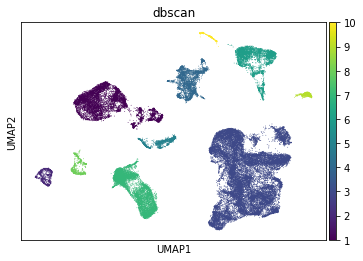

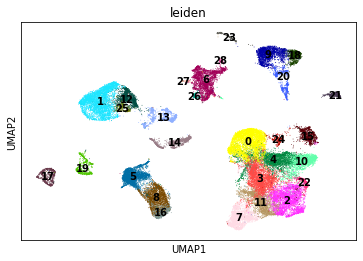

In [6]:
mit_data = sc.read_h5ad("/home/estelle860530/Getz_lab/data/scRNA_mit.h5ad")

sample2response={'620':'PD', '776_on':'PD','856_A':'PD','856_B':'PD',
                 '1224_post-FT':'PD', '1224_post-Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227_pre':'R',
                 '1009_on':'R',
                 '1130':'R'}

mit_data.obs['response']=mit_data.obs['orig.ident'].map(sample2response)

##Missing NK cells
sc.pl.umap(mit_data, color=['dbscan'], legend_loc="on data")

sc.pp.neighbors(mit_data, n_neighbors=20, n_pcs=40)
sc.tl.leiden(mit_data,resolution=1)
sc.pl.umap(mit_data, color=['leiden'], legend_loc="on data")

mit_data.obs.loc[mit_data.obs['leiden'] == '7' , 'dbscan'] = 11

num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',5:'Malignant',
          6:'B cell', 7: 'Malignant', 8:'CAF',9:'Dendritic',10:'Plasma B', 11:'NK'}

mit_data.obs['annotated_celltype']=mit_data.obs['dbscan'].map(num2name)

name2num={'Malignant':1, 'Endothelial':2, 'T cell':3, 
          'Macrophage':4, 'B cell':5,'CAF':6, 
          'Dendritic':7 ,'Plasma B':8, 'NK':9}

mit_data.obs['new_dbscan']=mit_data.obs['annotated_celltype'].map(name2num)




In [7]:
num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',5:'Malignant',
          6:'B cell', 7: 'Malignant', 8:'CAF',9:'Dendritic',10:'Plasma B', 11:'NK'}

mit_data.obs['annotated_celltype']=mit_data.obs['dbscan'].map(num2name)

name2num={'Malignant':0, 'Endothelial':1, 'T cell':2, 
          'Macrophage':3, 'B cell':4,'CAF':5, 
          'Dendritic':6 ,'Plasma B':7, 'NK':8}

mit_data.obs['new_dbscan']=mit_data.obs['annotated_celltype'].map(name2num)

In [6]:
multi_data = sc.read_h5ad("/home/estelle860530/Getz_lab/data/maarten.granular.h5ad")
#multi_data = sc.read_h5ad("/home/estelle860530/Getz_lab/data/maarten.h5ad")

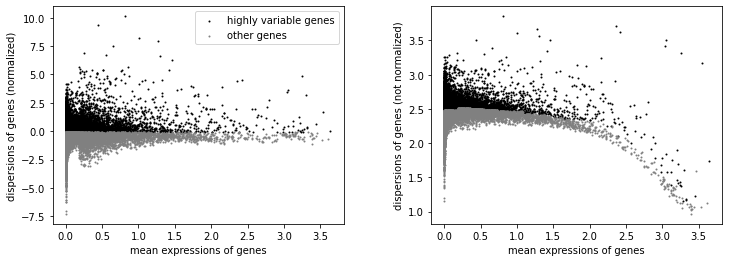

/home/estelle860530/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
sc.pp.normalize_total(multi_data, target_sum=1e4)
sc.pp.log1p(multi_data)
sc.pp.highly_variable_genes(multi_data, n_top_genes = 10000)
sc.pl.highly_variable_genes(multi_data)
multi_data.raw = multi_data  
multi_data = multi_data[:,multi_data.var.highly_variable]
sc.pp.scale(multi_data)

In [43]:
multi_data.obs

nGene    nUMI Subject Location    Sample  \
N10.EpiA.AAACGCACACAGCT    474  1144.0     N10      Epi  N10.EpiA   
N10.EpiA.AAACGCTGGTTCGA    697  1615.0     N10      Epi  N10.EpiA   
N10.EpiA.AAAGTTTGCCTAAG    652  1488.0     N10      Epi  N10.EpiA   
N10.EpiA.AAATCTGAGGTCTA    408   781.0     N10      Epi  N10.EpiA   
N10.EpiA.AACCTACTAGTTCG    568  1208.0     N10      Epi  N10.EpiA   
...                        ...     ...     ...      ...       ...   
N9.LPB.TGCTTAACGTTCGA     2495  8440.0      N9       LP    N9.LPB   
N9.LPB.TGGACTGACCTGAA     1319  3413.0      N9       LP    N9.LPB   
N9.LPB.TGGGTATGTCCTTA     1520  3975.0      N9       LP    N9.LPB   
N9.LPB.TGTACTTGCCGAAT      754  1603.0      N9       LP    N9.LPB   
N9.LPB.TTGCATTGGTCACA      546  1212.0      N9       LP    N9.LPB   

                                        Cluster    Health  \
N10.EpiA.AAACGCACACAGCT               CD8+ IELs   Healthy   
N10.EpiA.AAACGCTGGTTCGA               CD8+ IELs   Healthy   
N10.EpiA.AAAGTTTGCCTAAG               CD8+ IELs   Healthy   
N10.EpiA.AAATCTGAGGTCTA                 CD8+ LP   Healthy   
N10.EpiA.AACCTACTAGTTCG               CD8+ IELs   Healthy   
...                                         ...       ...   
N9.LPB.TGCTTAACGTTCGA    Post-capillary Venules  Inflamed   
N9.LPB.TGGACTGACCTGAA    Post-capillary Venules  Inflamed   
N9.LPB.TGGGTATGTCCTTA           WNT2B+ Fos-lo 1  Inflamed   
N9.LPB.TGTACTTGCCGAAT           WNT2B+ Fos-lo 2  Inflamed   
N9.LPB.TTGCATTGGTCACA    Post-capillary Venules  Inflamed   

                                      cell_type  
N10.EpiA.AAACGCACACAGCT               CD8+ IELs  
N10.EpiA.AAACGCTGGTTCGA               CD8+ IELs  
N10.EpiA.AAAGTTTGCCTAAG               CD8+ IELs  
N10.EpiA.AAATCTGAGGTCTA                 CD8+ LP  
N10.EpiA.AACCTACTAGTTCG               CD8+ IELs  
...                                         ...  
N9.LPB.TGCTTAACGTTCGA    Post-capillary Venules  
N9.LPB.TGGACTGACCTGAA    Post-capillary Venules  
N9.LPB.TGGGTATGTCCTTA               Fibroblasts  
N9.LPB.TGTACTTGCCGAAT               Fibroblasts  
N9.LPB.TTGCATTGGTCACA    Post-capillary Venules  

[65751 rows x 8 columns]

In [8]:
multi_numtoname = {i:name for i, name in enumerate( list(Counter(multi_data.obs['cell_type']).keys() ) ) }
multi_nametonum = {name:i for i, name in enumerate( list(Counter(multi_data.obs['cell_type']).keys() ) ) }
multi_data.obs['numeric_cell_type'] = multi_data.obs['cell_type'].map(multi_nametonum)

In [9]:
suerat_data = sc.read_h5ad("/home/estelle860530/Getz_lab/data/multi.h5ad")
sc.pp.normalize_total(suerat_data, target_sum=1e4)
sc.pp.log1p(suerat_data)
sc.pp.highly_variable_genes(suerat_data, n_top_genes = 10000)
suerat_data.raw = suerat_data  
suerat_data = suerat_data[:,suerat_data.var.highly_variable]
sc.pp.scale(suerat_data)
suerat_data_numtoname = {i:name for i, name in enumerate( list(Counter(suerat_data.obs['celltype.l2']).keys() ) ) }
suerat_data_nametonum = {name:i for i, name in enumerate( list(Counter(suerat_data.obs['celltype.l2']).keys() ) ) }
suerat_data.obs['numeric_celltype.l2'] = suerat_data.obs['celltype.l2'].map(suerat_data_nametonum)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/estelle860530/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### Annotated: Colon broad category data set , Uannotated: scATAC

In [32]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  
                                  multi_data.var_names, 
                                  return_indices=True)

# Colon
rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'
rna_y['name'] = 0


# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'
atac_y['name'] = 1


common_y = rna_y.append(atac_y)
common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

raw_rna = multi_data.X[:,y_ind]
raw_atac = scatac.X[:,x_ind]

common_matrix = np.concatenate((raw_rna, raw_atac), axis=0)

label = torch.as_tensor (common_y['name'].values)
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 2)

cvae_annotated1 = ExperimentDataset(raw_rna, 
                                   multi_data.obs.index, 
                                   xy, 
                                   one_hot_label[np.where(common_y.name==0)[0]], 
                                   rna_y['dbscan'])

cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     xy, 
                                     one_hot_label[np.where(common_y.name==1)[0]], 
                                     atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(common_matrix, 
                                  multi_data.obs.index.append(scatac.obs.index),
                                  xy,
                                  one_hot_label )

n_clusters= 12

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device

params.pretrain_batch = 256
params.epochs_pretrain = 50
params.epochs = 30
params.learning_rate = 1e-3
tau = 1e-3 ##0.2

== Dataset: Found 65540 items 
== Dataset: Found 9 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [33]:
cvae_mars1 = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated1], 
                      cvae_unannotated, cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = xy.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 2)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata1, cvae_landmarks1, cvae_scores1, cvae_training_history1, cvae_latent_tracker1, cvae_pretrain_latent1 , cave_pretrain_loss1 = cvae_mars1.train(evaluation_mode=True,save_all_embeddings=True)


Pretraining..
Pretraining Epoch 0, Loss: 388.2077331542969
Time:  4.445806980133057
Pretraining Epoch 1, Loss: 458.3510437011719
Time:  4.355400085449219
Pretraining Epoch 2, Loss: 434.4297790527344
Time:  4.319437742233276
Pretraining Epoch 3, Loss: 508.0559387207031
Time:  4.324614524841309
Pretraining Epoch 4, Loss: 436.14178466796875
Time:  4.445583820343018
Pretraining Epoch 5, Loss: 416.2469177246094
Time:  4.503068208694458
Pretraining Epoch 6, Loss: 351.6297912597656
Time:  4.4242894649505615
Pretraining Epoch 7, Loss: 396.32470703125
Time:  4.419114351272583
Pretraining Epoch 8, Loss: 416.8572082519531
Time:  4.398790121078491
Pretraining Epoch 9, Loss: 440.5947265625
Time:  4.65836501121521
Pretraining Epoch 10, Loss: 351.1300354003906
Time:  4.27974271774292
Pretraining Epoch 11, Loss: 379.47369384765625
Time:  4.478341341018677
Pretraining Epoch 12, Loss: 435.3723449707031
Time:  4.4374098777771
Pretraining Epoch 13, Loss: 392.2435302734375
Time:  4.418543338775635
Pretrain

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


... storing 'MARS_labels' as categorical


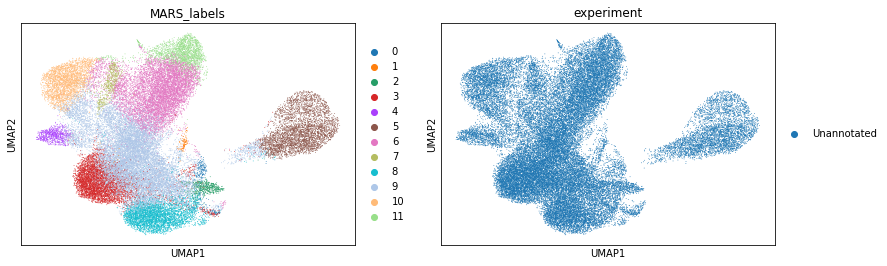

In [34]:
MARS_latent_umap_unanno(cvae_adata1, plot_gene_list = ['MARS_labels','experiment'], save=True)

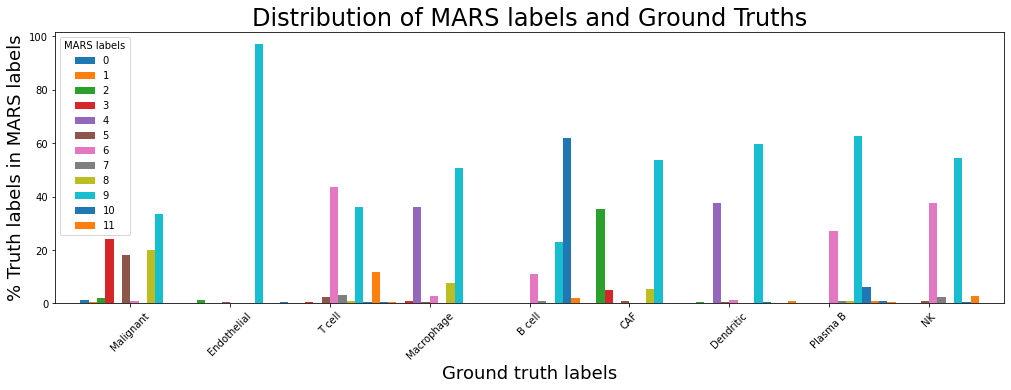

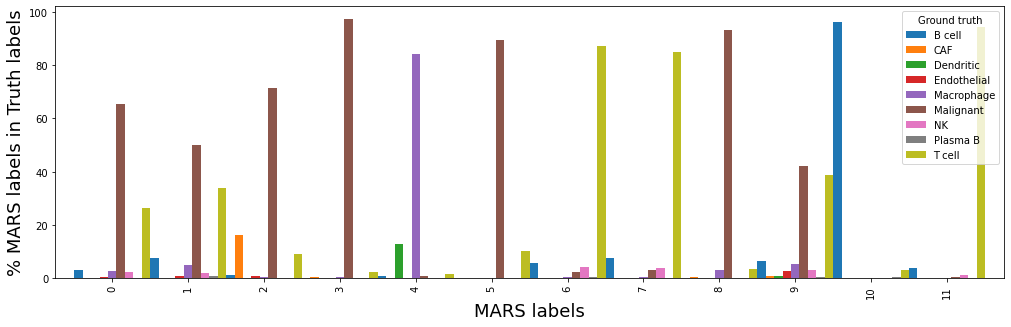

In [35]:
cell_type_assign(cvae_adata1, save = False)

In [36]:
Counter(cvae_adata1.obs.MARS_labels)

Counter({nan: 65540,
         9: 15533,
         8: 4160,
         3: 4857,
         5: 3931,
         6: 8364,
         10: 2731,
         11: 2095,
         4: 680,
         7: 596,
         0: 320,
         2: 545,
         1: 144})

In [37]:
name1 = cvae_mars.name_cell_types(cvae_adata1 ,
                                  cvae_landmarks1, 
                                  list(multi_nametonum.keys()),
                                  umap_reduce_dim=False
                                )


Cluster label: 0
NKs: 0.056906385886805265
CD8+ T cell: 0.1528992130188875
Fibroblasts: 0.18863462302029316
CD4+ T cell: 0.239469468727716
B cell: 0.3070898535864384

Cluster label: 1
B cell: 0.1377767437290474
CD8+ T cell: 0.15778739546006484
CD4+ T cell: 0.1664019219874994
Mast: 0.18549093745032597
Monocyte: 0.21045598295863138

Cluster label: 2
CD8+ T cell: 0.01290372605633569
CD4+ T cell: 0.021107172085697224
B cell: 0.02682083870290198
Monocyte: 0.028110378099276988
Fibroblasts: 0.9007224241983615

Cluster label: 3
Fibroblasts: 0.11793708416933833
Monocyte: 0.1219509433304233
CD8+ T cell: 0.16127730105459429
CD4+ T cell: 0.20056067978060985
B cell: 0.27481181574611513

Cluster label: 4
CD4+ T cell: 2.2507109672381135e-05
CD8+ T cell: 2.6333128279802173e-05
Fibroblasts: 4.894431800488583e-05
B cell: 0.00020012903402052992
Monocyte: 0.9996840955065802

Cluster label: 5
Endothelial cells: 0.020813548784989297
Monocyte: 0.023884381075592945
Glia: 0.03683767976396664
Mast: 0.074403782

In [38]:
cell_type = {}
prob ={}
for k in name1:
    if name1[k]!=[]:
        cell_type[k] = [k1[0] for k1 in name1[k]]
        prob[k] =  [k1[1] for k1 in name1[k]]

In [39]:
cell = pd.DataFrame(cell_type).T.reset_index()
p = pd.DataFrame(prob).T.reset_index()
p = p.drop(columns="index")
anno = pd.concat([cell, p], axis=1)
obs = cvae_adata.obs
obs = obs.reset_index()
obs = obs.merge(anno, left_on="MARS_labels", right_on="index")

In [40]:
obs.to_csv("colon_broad_anno.csv")

#### Annotated: Colon granular data set , Uannotated: scATAC

In [48]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  
                                  multi_data.var_names, 
                                  return_indices=True)

# Colon
rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'
rna_y['name'] = 0


# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'
atac_y['name'] = 1


common_y = rna_y.append(atac_y)
common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

raw_rna = multi_data.X[:,y_ind]
raw_atac = scatac.X[:,x_ind]

common_matrix = np.concatenate((raw_rna, raw_atac), axis=0)

In [52]:
label = torch.as_tensor (common_y['name'].values)
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 2)

In [53]:
cvae_annotated1 = ExperimentDataset(raw_rna, 
                                   multi_data.obs.index, 
                                   xy, 
                                   one_hot_label[np.where(common_y.name==0)[0]], 
                                   rna_y['dbscan'])

cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     xy, 
                                     one_hot_label[np.where(common_y.name==1)[0]], 
                                     atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(common_matrix, 
                                  multi_data.obs.index.append(scatac.obs.index),
                                  xy,
                                  one_hot_label )

n_clusters= 13

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device



== Dataset: Found 65751 items 
== Dataset: Found 29 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [55]:
params.pretrain_batch = 256
params.epochs_pretrain = 50
params.epochs = 30
params.learning_rate = 1e-3
tau = 1e-3 ##0.2


cvae_mars2 = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated1], 
                      cvae_unannotated, cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = xy.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 2)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata2, cvae_landmarks2, cvae_scores2, cvae_training_history2, cvae_latent_tracker2, cvae_pretrain_latent2 , cave_pretrain_loss2 = cvae_mars2.train(evaluation_mode=True,save_all_embeddings=True)


Pretraining..
Pretraining Epoch 0, Loss: 366.868896484375
Time:  5.312231540679932
Pretraining Epoch 1, Loss: 473.6007995605469
Time:  5.8017473220825195
Pretraining Epoch 2, Loss: 431.3506164550781
Time:  5.55989670753479
Pretraining Epoch 3, Loss: 515.5538330078125
Time:  5.175920009613037
Pretraining Epoch 4, Loss: 416.4737243652344
Time:  4.955568790435791
Pretraining Epoch 5, Loss: 407.9497985839844
Time:  5.291276931762695
Pretraining Epoch 6, Loss: 376.51739501953125
Time:  5.7033843994140625
Pretraining Epoch 7, Loss: 486.5833740234375
Time:  7.968889474868774
Pretraining Epoch 8, Loss: 433.0255126953125
Time:  6.792433738708496
Pretraining Epoch 9, Loss: 401.526123046875
Time:  6.136851787567139
Pretraining Epoch 10, Loss: 479.1314392089844
Time:  5.328296899795532
Pretraining Epoch 11, Loss: 396.7514953613281
Time:  5.746357202529907
Pretraining Epoch 12, Loss: 423.8912353515625
Time:  5.637730598449707
Pretraining Epoch 13, Loss: 362.9311218261719
Time:  5.639853000640869
Pr

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


... storing 'MARS_labels' as categorical


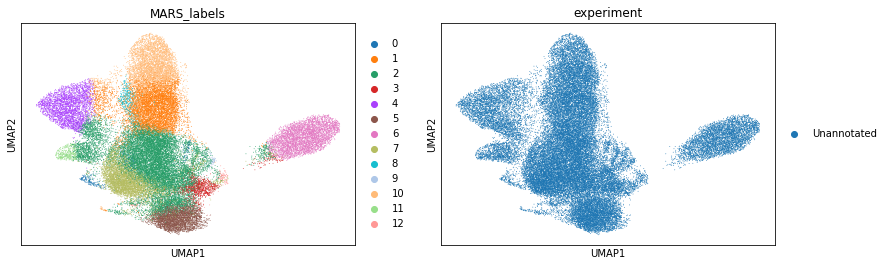

In [56]:
MARS_latent_umap_unanno(cvae_adata2, plot_gene_list = ['MARS_labels','experiment'], save=True)

... storing 'MARS_labels' as categorical


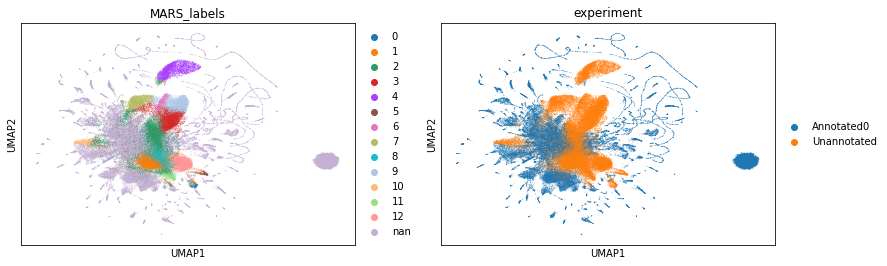

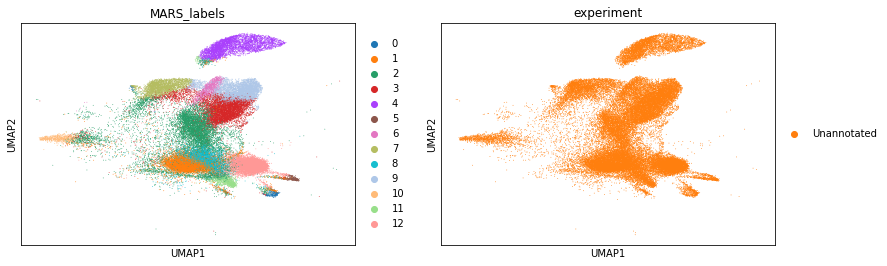

In [29]:
MARS_latent_umap(cvae_adata2, 
                 plot_gene_list = ['MARS_labels','experiment'], 
                 save = False)

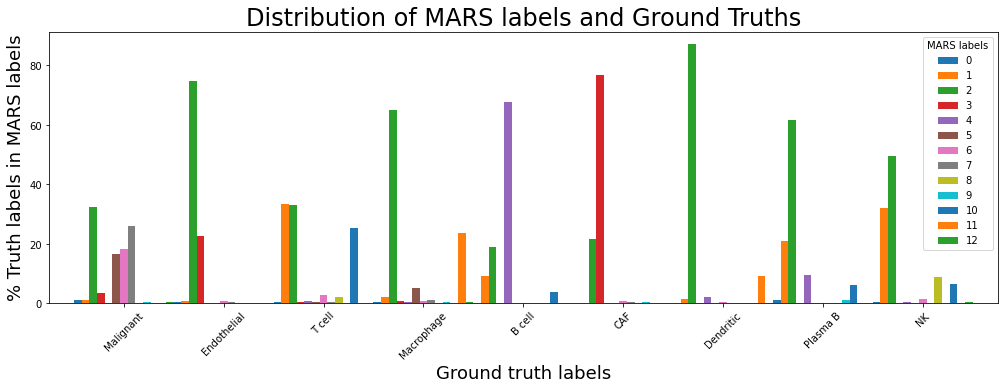

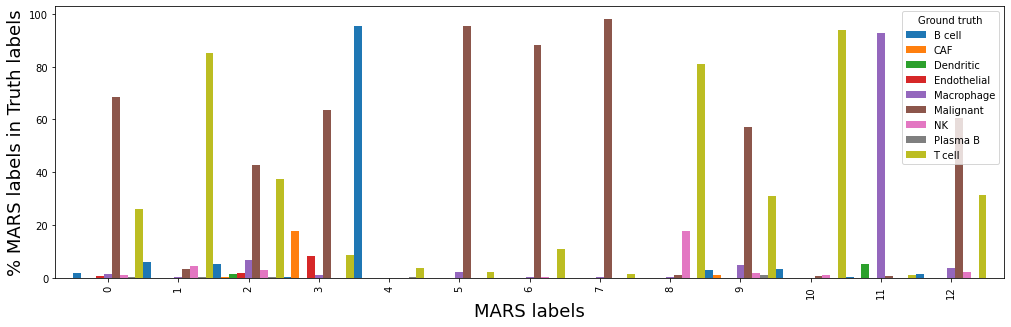

In [59]:
cell_type_assign(cvae_adata2, save = False)

In [158]:
n2 = cvae_mars2.name_cell_types(cvae_adata2[(cvae_adata2.obs['MARS_labels']==2)|
                                               (cvae_adata2.obs['experiment']=="Annotated0")
                                              ] ,
                                  cvae_landmarks2, 
                                  list(multi_nametonum.keys()),
                                  umap_reduce_dim=False
                                )


Cluster label: 2
CD4+ Memory: 0.07122436837702323
ILCs: 0.07767402212259544
Cycling T: 0.08548802455989607
MT-hi: 0.09306907578199328
Plasma: 0.09976240057977054


In [84]:
names = cvae_mars2.name_cell_types(cvae_adata2[(cvae_adata2.obs['MARS_labels']==0)|
                                               (cvae_adata2.obs['MARS_labels']==1)|
                                               (cvae_adata2.obs['experiment']=="Annotated0")
                                              ] ,
                                  cvae_landmarks2, 
                                  list(multi_nametonum.keys()),
                                  umap_reduce_dim=False
                                )


Cluster label: 0
Tregs: 0.07272676896578062
CD4+ Memory: 0.07314439433102568
ILCs: 0.07579290558413036
Cycling B: 0.08591785822703435
Plasma: 0.10336312606093719

Cluster label: 1
CD8+ LP: 0.0899436076382113
CD4+ Memory: 0.10578815832251902
CD4+ Activated Fos-hi: 0.10579673820713449
CD4+ Activated Fos-lo: 0.10731045777591924
Tregs: 0.12716256908773502


In [68]:
subset = cvae_adata2[ (cvae_adata2.obs['MARS_labels']!=2) & (cvae_adata2.obs['MARS_labels']!=0) &(cvae_adata2.obs['MARS_labels']!=1) ]

In [70]:
name = cvae_mars2.name_cell_types(subset ,
                                  cvae_landmarks2, 
                                  list(multi_nametonum.keys()),
                                  umap_reduce_dim=False
                                )


Cluster label: 3
CD69- Mast: 0.013263397591471746
Post-capillary Venules: 0.013268030199658554
Endothelial: 0.03497202277285655
Fibroblasts: 0.09457270802476053
Pericytes: 0.794432355434254

Cluster label: 4
ILCs: 0.003396626730793638
Plasma: 0.004079073376554041
Cycling B: 0.09547580689393785
GC: 0.1366157790062405
Follicular: 0.7461554619604176

Cluster label: 5
Plasma: 0.011903866023461619
ILCs: 0.02358382799407249
Pericytes: 0.11003221059193033
CD69- Mast: 0.11163186412099602
CD69+ Mast: 0.7022199974077413

Cluster label: 6
Microvascular: 0.05257844946103062
CD69- Mast: 0.08970455787829651
Post-capillary Venules: 0.1327838499893128
Pericytes: 0.25308332107365394
Endothelial: 0.36874255269019635

Cluster label: 7
CD4+ Memory: 0.08285007654942432
MT-hi: 0.09088380026795084
ILCs: 0.09573327568900968
Pericytes: 0.0961307772818299
Plasma: 0.12739594681523073

Cluster label: 8
CD4+ Activated Fos-hi: 0.07833488901935383
CD8+ IELs: 0.0798188163357069
Tregs: 0.08586765306924672
NKs: 0.1371

In [159]:
cell_type2 = {}
prob2 ={}
for k in n2:
    cell_type2[k] = [k1[0] for k1 in n2[k]]
    prob2[k] =  [k1[1] for k1 in n2[k]]

In [143]:
cell_type1 = {}
prob1 ={}
for k in names:
    cell_type1[k] = [k1[0] for k1 in names[k]]
    prob1[k] =  [k1[1] for k1 in names[k]]
    
cell_type = {}
prob ={}
for k in name:
    if name[k]!=[]:
        cell_type[k] = [k1[0] for k1 in name[k]]
        prob[k] =  [k1[1] for k1 in name[k]]

In [161]:
cell = pd.DataFrame(cell_type1).T.append(pd.DataFrame(cell_type2).T).append(pd.DataFrame(cell_type).T).reset_index()
p = pd.DataFrame(prob1).T.append(pd.DataFrame(prob2).T).append(pd.DataFrame(prob).T).reset_index()
p = p.drop(columns="index")
anno = pd.concat([cell, p], axis=1)

In [162]:
anno

index                      0                       1  \
0       0                  Tregs             CD4+ Memory   
1       1                CD8+ LP             CD4+ Memory   
2       2            CD4+ Memory                    ILCs   
3       3             CD69- Mast  Post-capillary Venules   
4       4                   ILCs                  Plasma   
5       5                 Plasma                    ILCs   
6       6          Microvascular              CD69- Mast   
7       7            CD4+ Memory                   MT-hi   
8       8  CD4+ Activated Fos-hi               CD8+ IELs   
9       9             CD8+ IL17+                  Plasma   
10     10                   ILCs             CD4+ Memory   
11     11                    DC1             Macrophages   
12     12             Follicular                   MT-hi   

                         2                       3            4         0  \
0                     ILCs               Cycling B       Plasma  0.072727   
1    CD4+ Activated Fos-hi   CD4+ Activated Fos-lo        Tregs  0.089944   
2                Cycling T                   MT-hi       Plasma  0.071224   
3              Endothelial             Fibroblasts    Pericytes  0.013263   
4                Cycling B                      GC   Follicular  0.003397   
5                Pericytes              CD69- Mast   CD69+ Mast  0.011904   
6   Post-capillary Venules               Pericytes  Endothelial  0.052578   
7                     ILCs               Pericytes       Plasma  0.082850   
8                    Tregs                     NKs      CD8+ LP  0.078335   
9              Fibroblasts                   MT-hi    CD8+ IELs  0.052552   
10   CD4+ Activated Fos-hi   CD4+ Activated Fos-lo        Tregs  0.111735   
11       Cycling Monocytes  Inflammatory Monocytes          DC2  0.001622   
12               Cycling B                  Plasma           GC  0.038557   

           1         2         3         4  
0   0.073144  0.075793  0.085918  0.103363  
1   0.105788  0.105797  0.107310  0.127163  
2   0.077674  0.085488  0.093069  0.099762  
3   0.013268  0.034972  0.094573  0.794432  
4   0.004079  0.095476  0.136616  0.746155  
5   0.023584  0.110032  0.111632  0.702220  
6   0.089705  0.132784  0.253083  0.368743  
7   0.090884  0.095733  0.096131  0.127396  
8   0.079819  0.085868  0.137146  0.171533  
9   0.053427  0.061144  0.094603  0.159502  
10  0.122477  0.123315  0.131710  0.148806  
11  0.003414  0.058315  0.335707  0.600940  
12  0.039568  0.060065  0.061174  0.505234

In [163]:
cell = pd.DataFrame(cell_type1).T.append(pd.DataFrame(cell_type2).T).append(pd.DataFrame(cell_type).T).reset_index()
p = pd.DataFrame(prob1).T.append(pd.DataFrame(prob2).T).append(pd.DataFrame(prob).T).reset_index()
p = p.drop(columns="index")
anno = pd.concat([cell, p], axis=1)
obs = cvae_adata2.obs
obs = obs.reset_index()
obs = obs.merge(anno, left_on="MARS_labels", right_on="index")

In [164]:
obs.to_csv("colon_anno.csv")

#### Annotated: Seurat PBMC , Unannotated: scATAC

In [7]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  
                                  suerat_data.var_names, 
                                  return_indices=True)

# # Colon
# rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
# rna_y.columns=['dbscan','annotated_celltype']
# rna_y = rna_y.copy()
# rna_y['omic'] = 'RNA'
# rna_y['name'] = 0

suerat_data_numtoname = {i:name for i, name in enumerate( list(Counter(suerat_data.obs['celltype.l2']).keys() ) ) }
suerat_data_nametonum = {name:i for i, name in enumerate( list(Counter(suerat_data.obs['celltype.l2']).keys() ) ) }
suerat_data.obs['numeric_celltype.l2'] = suerat_data.obs['celltype.l2'].map(suerat_data_nametonum)

# Seurat 
seraut_y = suerat_data.obs[['numeric_celltype.l2', 'celltype.l2']]
seraut_y.columns=['dbscan','annotated_celltype']
seraut_y = seraut_y.copy()
seraut_y['omic'] = 'RNA'
seraut_y['name'] = 0


# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'
atac_y['name'] = 1


common_y = seraut_y.append(atac_y)
common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

raw_rna = suerat_data.X[:,y_ind]
raw_atac = scatac.X[:,x_ind]

common_matrix = np.concatenate((raw_rna, raw_atac), axis=0)

In [10]:
label = torch.as_tensor (common_y['name'].values)
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 2)

cvae_annotated2 = ExperimentDataset(raw_rna, 
                                    suerat_data.obs.index, 
                                    xy, 
                                    one_hot_label[np.where(common_y.name==0)[0]], 
                                    seraut_y['dbscan'])


cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     xy, 
                                     one_hot_label[np.where(common_y.name==1)[0]], 
                                     atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(common_matrix, 
                                  suerat_data.obs.index.append(scatac.obs.index),
                                  xy,
                                  one_hot_label )

n_clusters= 13

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device

== Dataset: Found 161764 items 
== Dataset: Found 31 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [12]:
params.pretrain_batch = 256
params.epochs_pretrain = 50
params.epochs = 30
params.learning_rate = 1e-3
tau =1e-3 ##0.2

cvae_mars = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated2], 
                      cvae_unannotated, 
                      cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = xy.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 2)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata, cvae_landmarks, cvae_scores, cvae_training_history, cvae_latent_tracker, cvae_pretrain_latent , cave_pretrain_loss = cvae_mars.train(evaluation_mode=True,save_all_embeddings=True)


Pretraining..
Pretraining Epoch 0, Loss: 505.0921325683594
Time:  8.379843711853027
Pretraining Epoch 1, Loss: 631.6781616210938
Time:  8.189358472824097
Pretraining Epoch 2, Loss: 430.3752136230469
Time:  8.487910985946655
Pretraining Epoch 3, Loss: 662.5518798828125
Time:  8.433505058288574
Pretraining Epoch 4, Loss: 724.9668579101562
Time:  8.263872623443604
Pretraining Epoch 5, Loss: 524.30712890625
Time:  8.37913465499878
Pretraining Epoch 6, Loss: 447.7588806152344
Time:  8.712936162948608
Pretraining Epoch 7, Loss: 520.8359375
Time:  8.48982858657837
Pretraining Epoch 8, Loss: 508.1151123046875
Time:  8.490958213806152
Pretraining Epoch 9, Loss: 563.9703369140625
Time:  8.404378652572632
Pretraining Epoch 10, Loss: 517.2632446289062
Time:  8.528250932693481
Pretraining Epoch 11, Loss: 614.7891235351562
Time:  8.205449104309082
Pretraining Epoch 12, Loss: 518.8167724609375
Time:  8.595932006835938
Pretraining Epoch 13, Loss: 394.83538818359375
Time:  8.317317724227905
Pretraining

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


... storing 'MARS_labels' as categorical


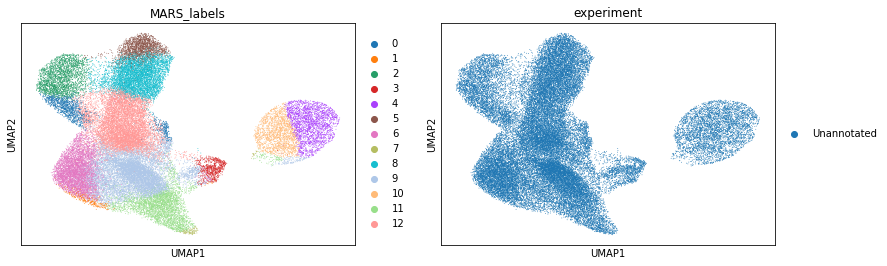

In [13]:
MARS_latent_umap_unanno(cvae_adata, plot_gene_list = ['MARS_labels','experiment'], save=True)

In [ ]:
cell_type_assign(cvae_adata, save = False)

In [14]:
Counter(cvae_adata.obs.MARS_labels)

Counter({nan: 161764,
         9: 9800,
         6: 5137,
         11: 3673,
         12: 8617,
         4: 2306,
         10: 1885,
         0: 1465,
         8: 5490,
         5: 1926,
         2: 2480,
         3: 725,
         1: 330,
         7: 122})

In [17]:
Counter(cvae_adata.obs.MARS_labels)
name2 = cvae_mars.name_cell_types(cvae_adata ,
                                  cvae_landmarks, 
                                  list(suerat_data_nametonum.keys()),
                                  umap_reduce_dim=False
                                )


Cluster label: 0
CD16 Mono: 0.01703882855267209
B memory: 0.025096658089913872
B intermediate: 0.03895461485115254
CD14 Mono: 0.1399259846266776
B naive: 0.7440125147558132

Cluster label: 1
Treg: 0.06502927138042278
ILC: 0.09616165127682454
NK Proliferating: 0.10490888123537925
CD4 Naive: 0.16805158651454577
CD8 Naive: 0.26178080015495464

Cluster label: 2
B memory: 0.014621579389004496
CD16 Mono: 0.015284687511083458
B intermediate: 0.021901311537692137
CD14 Mono: 0.22641828744260917
B naive: 0.7128578528174905

Cluster label: 3
ILC: 0.046898283735550876
CD8 Proliferating: 0.05648030813981182
cDC2: 0.14941695835865015
CD14 Mono: 0.15010884494579715
Doublet: 0.16819067252048098

Cluster label: 4
CD4 TCM: 0.03836428272424449
CD14 Mono: 0.040962951428196503
CD4 Naive: 0.0698942105740709
CD8 Naive: 0.07793305052697642
NK Proliferating: 0.1617752412492868

Cluster label: 5
CD8 TEM: 0.0024199470101731167
CD4 CTL: 0.0024369594408050993
CD16 Mono: 0.0035125615417862716
Treg: 0.0049862663654

In [18]:
cell_type = {}
prob ={}
for k in name2:
    if name2[k]!=[]:
        cell_type[k] = [k1[0] for k1 in name2[k]]
        prob[k] =  [k1[1] for k1 in name2[k]]

In [19]:
cell = pd.DataFrame(cell_type).T.reset_index()
p = pd.DataFrame(prob).T.reset_index()
p = p.drop(columns="index")
anno = pd.concat([cell, p], axis=1)
obs = cvae_adata.obs
obs = obs.reset_index()
obs = obs.merge(anno, left_on="MARS_labels", right_on="index")

In [22]:
obs.to_csv("seurat_level2_anno.csv")

#### Annotated: Maarten's colon set + Seurat PBMC data (cell type naming level 2), Unannotated: scATAC¶


In [10]:
suerat_data_numtoname = {i+29:name for i, name in enumerate( list(Counter(suerat_data.obs['celltype.l2']).keys() ) ) }
suerat_data_nametonum = {name:i+29 for i, name in enumerate( list(Counter(suerat_data.obs['celltype.l2']).keys() ) ) }

suerat_data.obs['numeric_celltype.l2'] = suerat_data.obs['celltype.l2'].map(suerat_data_nametonum)

In [11]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  
                                  multi_data.var_names, 
                                  return_indices=True)
gene_intersection = np.intersect1d(xy, suerat_data.var_names)


# Get the indices for all three datasets
_, _, multi_ind = np.intersect1d(gene_intersection,  multi_data.var_names, return_indices=True)
_, _, seurat_ind = np.intersect1d(gene_intersection,  suerat_data.var_names, return_indices=True)

_, _, atac_ind = np.intersect1d(gene_intersection,  scatac.var_names, return_indices=True)

In [12]:
# Colon
rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'
rna_y['name'] = 0

# Seurat 
seraut_y = suerat_data.obs[['numeric_celltype.l2', 'celltype.l2']]
seraut_y.columns=['dbscan','annotated_celltype']
seraut_y = seraut_y.copy()
seraut_y['omic'] = 'RNA'
seraut_y['name'] = 1

# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'
atac_y['name'] = 2

##Combine all y 
common_y = rna_y.append(seraut_y)
common_y = common_y.append(atac_y)

common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']


In [13]:
raw_rna = multi_data.X[:,multi_ind]
raw_seurat = suerat_data.X[:,seurat_ind]

raw_atac = scatac.X[:,atac_ind]

common_matrix = np.concatenate((raw_rna, raw_seurat, raw_atac), axis=0)

label = torch.as_tensor (common_y['name'].values)
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 3)

In [14]:
cvae_annotated1 = ExperimentDataset(raw_rna, 
                                   multi_data.obs.index, 
                                   gene_intersection, 
                                   one_hot_label[np.where(common_y.name==0)[0]], 
                                   rna_y['dbscan'])

cvae_annotated2 = ExperimentDataset(raw_seurat, 
                                    suerat_data.obs.index, 
                                    gene_intersection, 
                                    one_hot_label[np.where(common_y.name==1)[0]], 
                                    seraut_y['dbscan'])


cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     gene_intersection, 
                                     one_hot_label[np.where(common_y.name==2)[0]], 
                                     atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(common_matrix, 
                                  multi_data.obs.index.append(suerat_data.obs.index).append(scatac.obs.index),
                                  gene_intersection,
                                  one_hot_label )

n_clusters= 13

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device

params.pretrain_batch = 128

params.epochs_pretrain = 50
params.epochs = 30

== Dataset: Found 65751 items 
== Dataset: Found 29 classes
== Dataset: Found 161764 items 
== Dataset: Found 31 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [16]:
params.learning_rate = 1e-4
tau =1e-3 ##0.2


cvae_mars4 = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated1, cvae_annotated2], 
                      cvae_unannotated, 
                       cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = gene_intersection.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 3)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata4, cvae_landmarks4, cvae_scores4, cvae_training_history4, cvae_latent_tracker4, cvae_pretrain_latent4 , cave_pretrain_loss4 = cvae_mars4.train(evaluation_mode=True,save_all_embeddings=True)



Pretraining..
Pretraining Epoch 0, Loss: 168.49574279785156
Time:  15.321683168411255
Pretraining Epoch 1, Loss: 334.96124267578125
Time:  15.496417999267578
Pretraining Epoch 2, Loss: 227.6992645263672
Time:  14.91988468170166
Pretraining Epoch 3, Loss: 177.89785766601562
Time:  15.163520097732544
Pretraining Epoch 4, Loss: 250.7777099609375
Time:  14.79054307937622
Pretraining Epoch 5, Loss: 229.61959838867188
Time:  14.8363356590271
Pretraining Epoch 6, Loss: 175.97128295898438
Time:  14.452012062072754
Pretraining Epoch 7, Loss: 247.34788513183594
Time:  15.25644564628601
Pretraining Epoch 8, Loss: 172.85203552246094
Time:  14.904662132263184
Pretraining Epoch 9, Loss: 180.1320343017578
Time:  14.880615949630737
Pretraining Epoch 10, Loss: 194.12762451171875
Time:  14.601290464401245
Pretraining Epoch 11, Loss: 183.04034423828125
Time:  14.216504335403442
Pretraining Epoch 12, Loss: 144.6519775390625
Time:  13.925242185592651
Pretraining Epoch 13, Loss: 193.02879333496094
Time:  14

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [17]:
cvae_adata4.obs

truth_labels MARS_labels  \
N13.LPB.ATGCCGCTTCCTAT-Annotated0                         21         NaN   
N18.LPA.TACCATTGGCTGAT-Annotated0                          7         NaN   
N18.LPA.GTGCCACTCTGACA-Annotated0                         14         NaN   
N26.LPA.GGATGTTGTAGCTAAA-Annotated0                       14         NaN   
N17.LPA.GTTAGGTGCTTCCG-Annotated0                         14         NaN   
...                                                      ...         ...   
pt856_B_TAGCATGGTTTAGAAG-1-Unannotated                     3           3   
pt509_post_GGATGAGGTTCTGAGT-1-Unannotated                  3           0   
pt1224_post_Cln_CACCTGTTCCATAGGT-1-Unannotated             1          10   
pt509_post_GGAACTTGTAAGCCTT-1-Unannotated                  1          12   
pt509_post_GTGCCAGCACTTATGG-1-Unannotated                  3           2   

                                                 experiment  
N13.LPB.ATGCCGCTTCCTAT-Annotated0                Annotated0  
N18.LPA.TACCATTGGCTGAT-Annotated0                Annotated0  
N18.LPA.GTGCCACTCTGACA-Annotated0                Annotated0  
N26.LPA.GGATGTTGTAGCTAAA-Annotated0              Annotated0  
N17.LPA.GTTAGGTGCTTCCG-Annotated0                Annotated0  
...                                                     ...  
pt856_B_TAGCATGGTTTAGAAG-1-Unannotated          Unannotated  
pt509_post_GGATGAGGTTCTGAGT-1-Unannotated       Unannotated  
pt1224_post_Cln_CACCTGTTCCATAGGT-1-Unannotated  Unannotated  
pt509_post_GGAACTTGTAAGCCTT-1-Unannotated       Unannotated  
pt509_post_GTGCCAGCACTTATGG-1-Unannotated       Unannotated  

[271471 rows x 3 columns]

... storing 'MARS_labels' as categorical


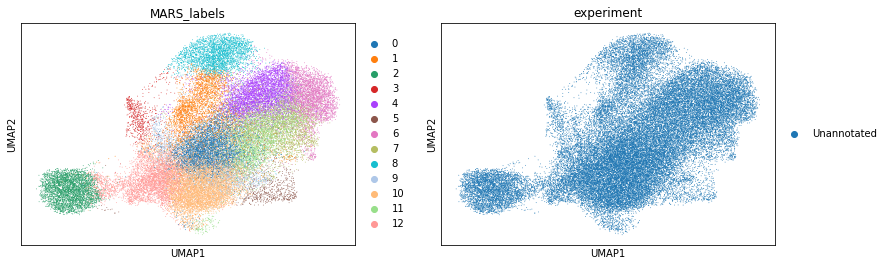

In [18]:
MARS_latent_umap_unanno(cvae_adata4, plot_gene_list = ['MARS_labels','experiment'], save=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
... storing 'MARS_labels' as categorical
... storing 'label_name' as categorical


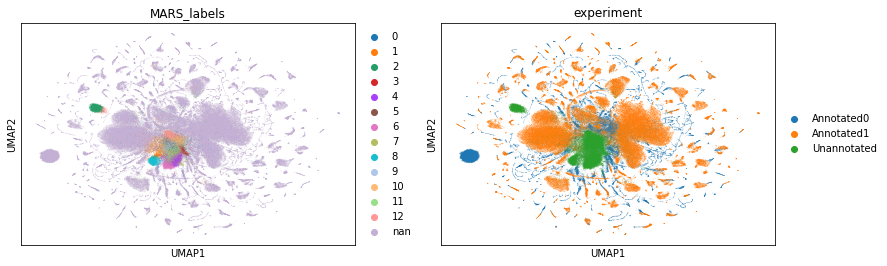

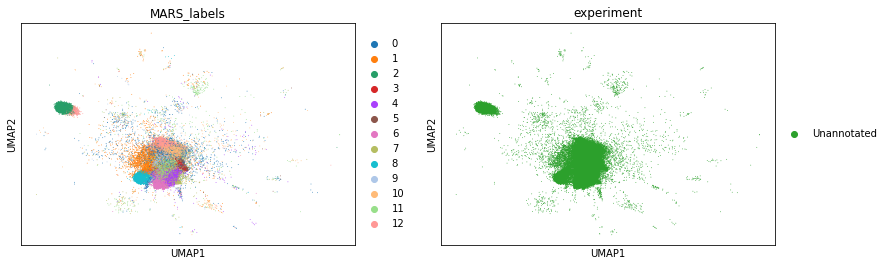

In [29]:
MARS_latent_umap(cvae_adata4, plot_gene_list = ['MARS_labels','experiment'], save=False)

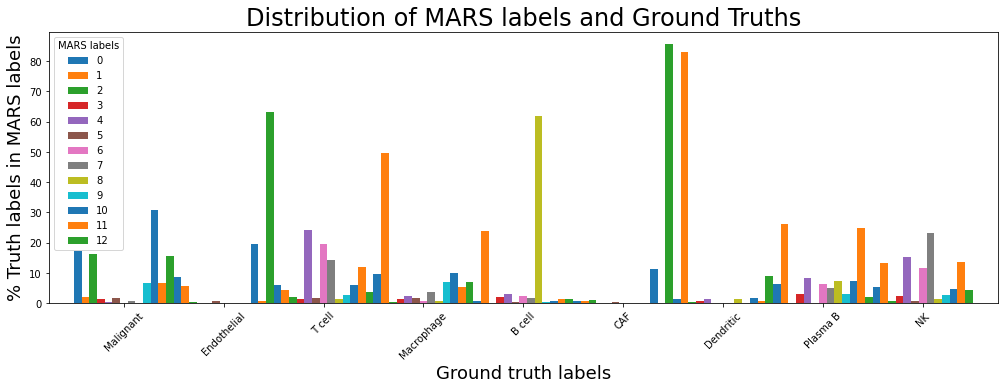

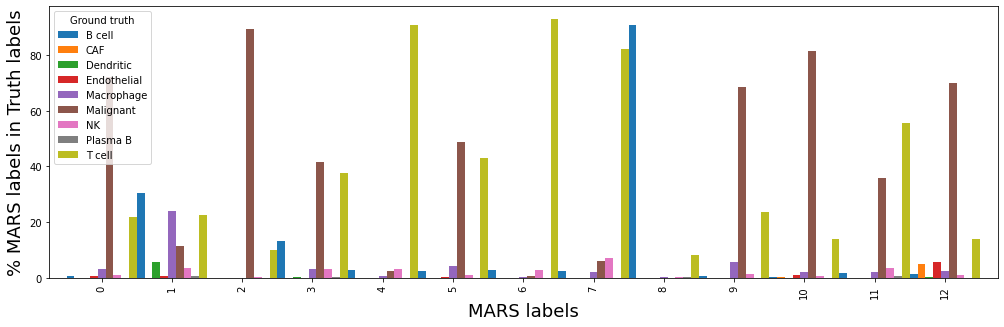

In [19]:
cell_type_assign(cvae_adata4, save = False)

In [20]:
Counter(cvae_adata4.obs.MARS_labels)

Counter({nan: 227515,
         4: 4467,
         0: 4657,
         2: 3566,
         9: 1940,
         5: 677,
         1: 3290,
         10: 7416,
         3: 656,
         7: 2953,
         6: 3516,
         11: 3584,
         8: 2896,
         12: 4338})

In [21]:
labeled_name=[]
tmp = [labeled_name.append(k) for k in multi_nametonum.keys()]
tmp = [labeled_name.append(k) for k in suerat_data_nametonum.keys()]

In [23]:
name4 = cvae_mars4.name_cell_types(cvae_adata4 ,
                                   cvae_landmarks4, 
                                   labeled_name,
                                   umap_reduce_dim=False
                                )


Cluster label: 0
CD8+ LP: 0.039917222394266365
CD4+ Memory: 0.04195713676020244
CD4+ Activated Fos-hi: 0.04257014639029558
CD4+ Activated Fos-lo: 0.04467504777577371
Plasma: 0.04633658529406351

Cluster label: 1
Macrophages: 0.05214919884610474
DC2: 0.053967064497364
Cycling B: 0.057999565284524456
Cycling Monocytes: 0.062294906997705436
Follicular: 0.06442571256708775

Cluster label: 2
Macrophages: 0.027278531647617527
CD8+ IL17+: 0.028727669402283103
CD16 Mono: 0.02959502725997292
Fibroblasts: 0.10513259567151509
Pericytes: 0.3049103087256811

Cluster label: 3
Follicular: 0.04166562862519814
CD8+ LP: 0.043115379115753714
Tregs: 0.043603122385458146
NK_CD56bright: 0.06140475903394066
B memory: 0.06608244073364337

Cluster label: 4
Tregs: 0.04992208414481421
CD4+ Memory: 0.05015765881791262
CD4+ Activated Fos-lo: 0.05122687296700245
CD4+ Activated Fos-hi: 0.05195156809479176
CD4 TCM: 0.06484901332718919

Cluster label: 5
CD4+ Memory: 0.04697118087090087
MT-hi: 0.047327869991985475
Tre

In [24]:
cell_type = {}
prob ={}
for k in name4:
    if name4[k]!=[]:
        cell_type[k] = [k1[0] for k1 in name4[k]]
        prob[k] =  [k1[1] for k1 in name4[k]]

In [27]:
cell = pd.DataFrame(cell_type).T.reset_index()
p = pd.DataFrame(prob).T.reset_index()
p = p.drop(columns="index")
anno = pd.concat([cell, p], axis=1)
obs = cvae_adata4.obs
obs = obs.reset_index()
obs = obs.merge(anno, left_on="MARS_labels", right_on="index")

In [28]:
obs.to_csv("colon_seurat_anno.csv")

#### Annotated: Maarten's colon set + Seurat PBMC data (cell type naming level 2) + MIT scRNA , Unannotated: scATAC

In [46]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  
                                  multi_data.var_names, 
                                  return_indices=True)
gene_intersection = np.intersect1d(xy, mit_data.var_names)
gene_intersection = np.intersect1d(gene_intersection, suerat_data.var_names)


# Get the indices for all three datasets
_, _, mit_ind = np.intersect1d(gene_intersection,  mit_data.var_names, return_indices=True)
_, _, multi_ind = np.intersect1d(gene_intersection,  multi_data.var_names, return_indices=True)
_, _, seurat_ind = np.intersect1d(gene_intersection,  suerat_data.var_names, return_indices=True)

_, _, atac_ind = np.intersect1d(gene_intersection,  scatac.var_names, return_indices=True)

In [182]:
# Colon
rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'
rna_y['name'] = 0

# Seurat 
seraut_y = suerat_data.obs[['numeric_celltype.l2', 'celltype.l2']]
seraut_y.columns=['dbscan','annotated_celltype']
seraut_y = seraut_y.copy()
seraut_y['omic'] = 'RNA'
seraut_y['name'] = 1

# MIT
mit_y = mit_data.obs[['new_dbscan','annotated_celltype']]
mit_y.columns=['dbscan','annotated_celltype']
mit_y = mit_y.copy()
mit_y['omic'] = 'RNA'
mit_y['name'] = 2

# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'
atac_y['name'] = 3

##Combine all y 
common_y = rna_y.append(seraut_y)
common_y = common_y.append(mit_y)
common_y = common_y.append(atac_y)

common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']


In [183]:
raw_rna = multi_data.X[:,multi_ind]
raw_seurat = suerat_data.X[:,seurat_ind]
raw_mit = mit_data.X[:,mit_ind]

raw_atac = scatac.X[:,atac_ind]

common_matrix = np.concatenate((raw_rna, raw_seurat, raw_mit, raw_atac), axis=0)

In [186]:
label = torch.as_tensor (common_y['name'].values)
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 4)

In [187]:
cvae_annotated1 = ExperimentDataset(raw_rna, 
                                   multi_data.obs.index, 
                                   gene_intersection, 
                                   one_hot_label[np.where(common_y.name==0)[0]], 
                                   rna_y['dbscan'])

cvae_annotated2 = ExperimentDataset(raw_seurat, 
                                    suerat_data.obs.index, 
                                    gene_intersection, 
                                    one_hot_label[np.where(common_y.name==1)[0]], 
                                    seraut_y['dbscan'])

cvae_annotated3 = ExperimentDataset(raw_mit, 
                                    mit_data.obs.index,
                                    gene_intersection, 
                                    one_hot_label[np.where(common_y.name==2)[0]], 
                                    mit_y['dbscan'])

cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     gene_intersection, 
                                     one_hot_label[np.where(common_y.name==3)[0]], 
                                     atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(common_matrix, 
                                  multi_data.obs.index.append(suerat_data.obs.index).append(mit_data.obs.index).append(scatac.obs.index),
                                  gene_intersection,
                                  one_hot_label )

n_clusters= 13

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device

params.pretrain_batch = 128

params.epochs_pretrain = 15
params.epochs = 15

== Dataset: Found 65540 items 
== Dataset: Found 9 classes
== Dataset: Found 161764 items 
== Dataset: Found 31 classes
== Dataset: Found 46089 items 
== Dataset: Found 9 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [188]:
params.learning_rate = 1e-3
tau = tau=1e-3 ##0.2


cvae_mars3 = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated1, cvae_annotated2, cvae_annotated3], 
                      cvae_unannotated, cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = gene_intersection.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 4)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata3, cvae_landmarks3, cvae_scores3, cvae_training_history3, cvae_latent_tracker3, cvae_pretrain_latent3 , cave_pretrain_loss3 = cvae_mars3.train(evaluation_mode=True,save_all_embeddings=True)



Pretraining..
Pretraining Epoch 0, Loss: 23.993600845336914
Time:  15.03756332397461
Pretraining Epoch 1, Loss: 23.09135627746582
Time:  15.325014352798462
Pretraining Epoch 2, Loss: 54.35676574707031
Time:  14.26610517501831
Pretraining Epoch 3, Loss: 24.797487258911133
Time:  14.631043672561646
Pretraining Epoch 4, Loss: 20.99492835998535
Time:  14.256811380386353
Pretraining Epoch 5, Loss: 18.787120819091797
Time:  14.697139978408813
Pretraining Epoch 6, Loss: 12.175592422485352
Time:  15.53479266166687
Pretraining Epoch 7, Loss: 28.530689239501953
Time:  14.971319437026978
Pretraining Epoch 8, Loss: 48.73394775390625
Time:  14.864025831222534
Pretraining Epoch 9, Loss: 16.420307159423828
Time:  15.577956438064575
Pretraining Epoch 10, Loss: 23.296001434326172
Time:  15.267861604690552
Pretraining Epoch 11, Loss: 16.460214614868164
Time:  15.549351930618286
Pretraining Epoch 12, Loss: 9.845548629760742
Time:  14.894659757614136
Pretraining Epoch 13, Loss: 14.140231132507324
Time:  1

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [189]:
cvae_scores3

{'precision': 0.29517534461424105,
 'nmi': 0.192612843918276,
 'adj_rand': 0.17498784828736533,
 'recall': 0.25822025050091424,
 'f1_score': 0.24220840288469325,
 'adj_mi': 0.19200976191078148,
 'accuracy': 0.4887614887614888}

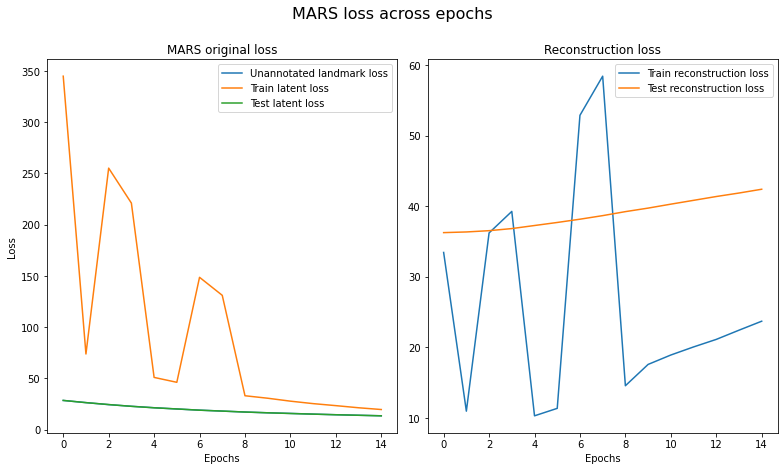

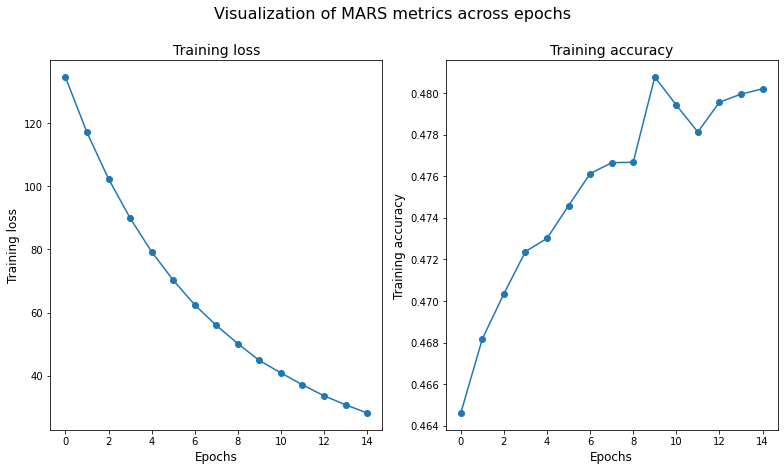

In [190]:
MARS_loss_tracker (cvae_training_history3, save = False)
MARS_history (cvae_training_history3, save = False)

... storing 'MARS_labels' as categorical


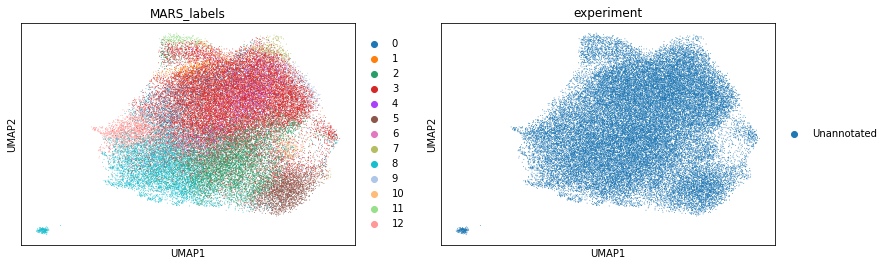

In [192]:
MARS_latent_umap_unanno(cvae_adata3, plot_gene_list = ['MARS_labels','experiment'], save=False)

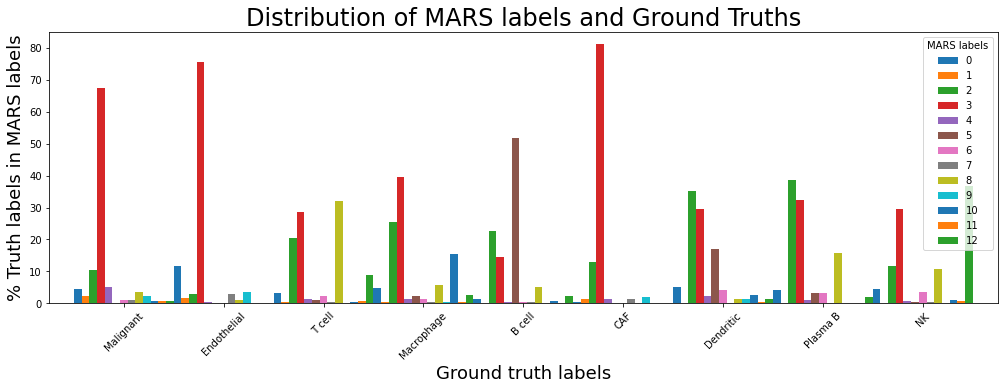

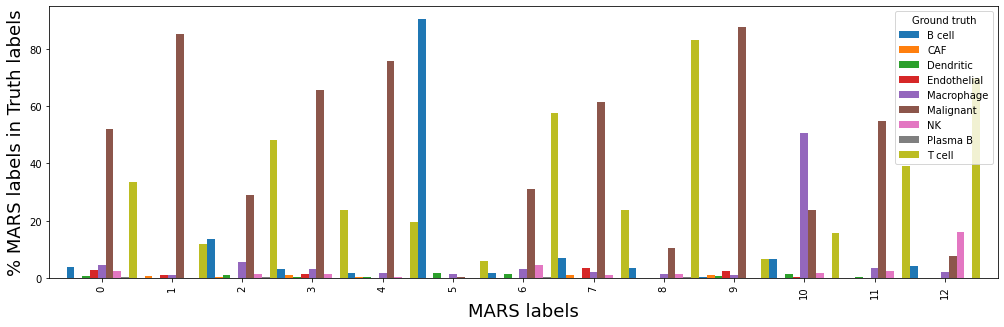

In [193]:
cell_type_assign(cvae_adata3, save=False)

... storing 'MARS_labels' as categorical
... storing 'label_name' as categorical


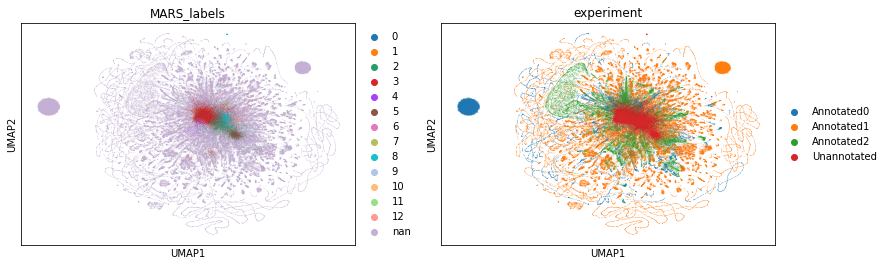

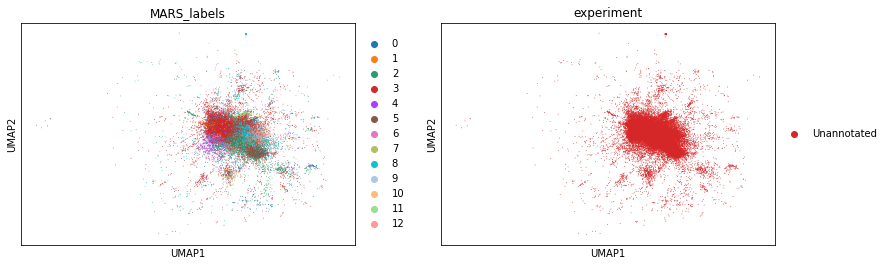

In [194]:
MARS_latent_umap(cvae_adata3, plot_gene_list = ['MARS_labels','experiment'], save=False)

#### Annotated: Suerat PBMC + MITscRNA , Uannotated: scATAC 

In [161]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  
                                  suerat_data.var_names, 
                                  return_indices=True)
gene_intersection = np.intersect1d(xy, mit_data.var_names)

# Get the indices for all three datasets
_, _, mit_ind = np.intersect1d(gene_intersection,  mit_data.var_names, return_indices=True)
#_, _, multi_ind = np.intersect1d(gene_intersection,  multi_data.var_names, return_indices=True)
_, _, seurat_ind = np.intersect1d(gene_intersection,  suerat_data.var_names, return_indices=True)

_, _, atac_ind = np.intersect1d(gene_intersection,  scatac.var_names, return_indices=True)

In [168]:
# # Colon
# rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
# rna_y.columns=['dbscan','annotated_celltype']
# rna_y = rna_y.copy()
# rna_y['omic'] = 'RNA'
# rna_y['name'] = 0

# Seurat 
seraut_y = suerat_data.obs[['numeric_celltype.l2', 'celltype.l2']]
seraut_y.columns=['dbscan','annotated_celltype']
seraut_y = seraut_y.copy()
seraut_y['omic'] = 'RNA'
seraut_y['name'] = 0

# MIT
mit_y = mit_data.obs[['new_dbscan','annotated_celltype']]
mit_y.columns=['dbscan','annotated_celltype']
mit_y = mit_y.copy()
mit_y['omic'] = 'RNA'
mit_y['name'] = 1

# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'
atac_y['name'] = 2

##Combine all y 
common_y = seraut_y.append(mit_y)
common_y = common_y.append(atac_y)

common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

In [169]:
#raw_rna = multi_data.X[:,multi_ind]
raw_seurat = suerat_data.X[:,seurat_ind]
raw_mit = mit_data.X[:,mit_ind]

raw_atac = scatac.X[:,atac_ind]

common_matrix = np.concatenate((raw_seurat, raw_mit, raw_atac), axis=0)

In [170]:
common_matrix.shape

(251809, 146)

In [171]:
label = torch.as_tensor (common_y['name'].values)
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 3)

In [173]:
cvae_annotated1 = ExperimentDataset(raw_seurat, 
                                   suerat_data.obs.index, 
                                   gene_intersection, 
                                   one_hot_label[np.where(common_y.name==0)[0]], 
                                   seraut_y['dbscan'])

cvae_annotated2 = ExperimentDataset(raw_mit, 
                                     mit_data.obs.index, 
                                     gene_intersection, 
                                     one_hot_label[np.where(common_y.name==1)[0]], 
                                     mit_y['dbscan'])

cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     gene_intersection, 
                                     one_hot_label[np.where(common_y.name==2)[0]], 
                                     atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(common_matrix, 
                                  suerat_data.obs.index.append(mit_data.obs.index).append(scatac.obs.index),
                                  gene_intersection,
                                  one_hot_label )

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device

params.pretrain_batch = 128

params.epochs_pretrain = 30
params.epochs = 30

== Dataset: Found 161764 items 
== Dataset: Found 31 classes
== Dataset: Found 46089 items 
== Dataset: Found 9 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [174]:
n_clusters= 13
params.epochs_pretrain = 30
params.learning_rate = 1e-3
tau = tau=1e-3 ##0.2


cvae_mars13 = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated1, cvae_annotated2], 
                      cvae_unannotated, cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = gene_intersection.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 3)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata13, cvae_landmarks13, cvae_scores13, cvae_training_history13, cvae_latent_tracker13, cvae_pretrain_latent13 , cave_pretrain_loss13 = cvae_mars13.train(evaluation_mode=True,save_all_embeddings=True)



Pretraining..
Pretraining Epoch 0, Loss: 98.45068359375
Time:  12.994263172149658
Pretraining Epoch 1, Loss: 71.60713958740234
Time:  12.766628503799438
Pretraining Epoch 2, Loss: 85.48260498046875
Time:  13.197631597518921
Pretraining Epoch 3, Loss: 81.89885711669922
Time:  13.29749584197998
Pretraining Epoch 4, Loss: 59.168331146240234
Time:  15.41806697845459
Pretraining Epoch 5, Loss: 83.30274963378906
Time:  13.976378440856934
Pretraining Epoch 6, Loss: 67.79479217529297
Time:  13.684477090835571
Pretraining Epoch 7, Loss: 142.2626495361328
Time:  12.903915643692017
Pretraining Epoch 8, Loss: 133.30258178710938
Time:  13.180009841918945
Pretraining Epoch 9, Loss: 88.34020233154297
Time:  13.280453205108643
Pretraining Epoch 10, Loss: 81.65100860595703
Time:  14.077790260314941
Pretraining Epoch 11, Loss: 45.67755889892578
Time:  14.626975297927856
Pretraining Epoch 12, Loss: 42.1655158996582
Time:  13.130011320114136
Pretraining Epoch 13, Loss: 102.89640045166016
Time:  13.5119156

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [175]:
cvae_scores13

{'precision': 0.36557918705335823,
 'nmi': 0.19526159039197422,
 'adj_rand': 0.10052294093913312,
 'recall': 0.19494188863537965,
 'f1_score': 0.2025924542314597,
 'adj_mi': 0.1945589912615719,
 'accuracy': 0.4998179998179998}

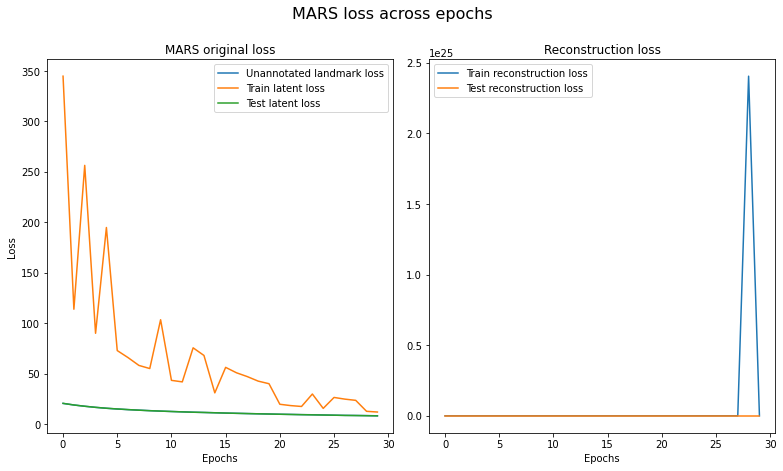

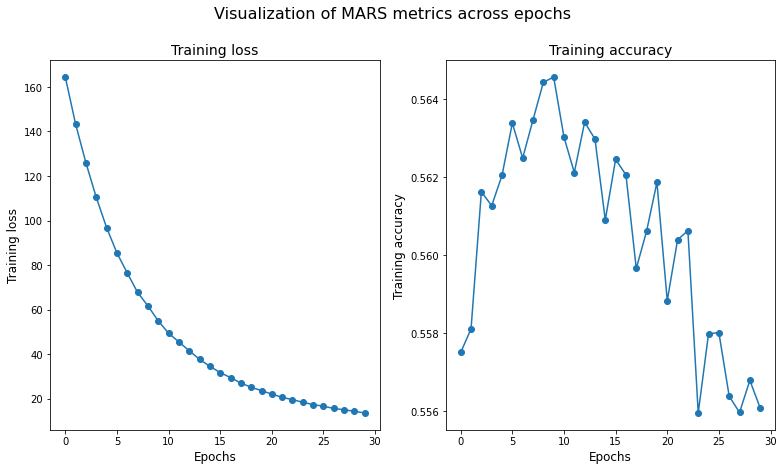

In [176]:
MARS_loss_tracker (cvae_training_history13, save = False)
MARS_history (cvae_training_history13, save = False)

... storing 'MARS_labels' as categorical


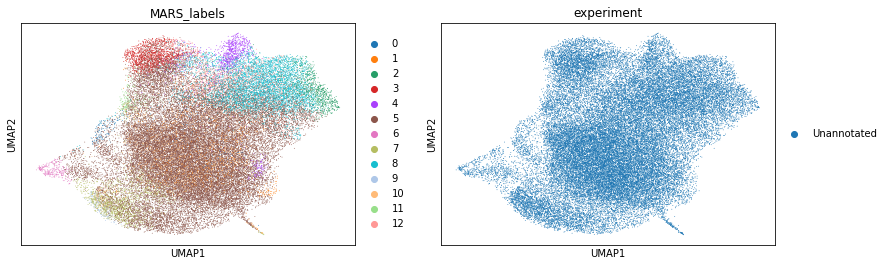

In [177]:
MARS_latent_umap_unanno(cvae_adata13, plot_gene_list = ['MARS_labels','experiment'], save=False)

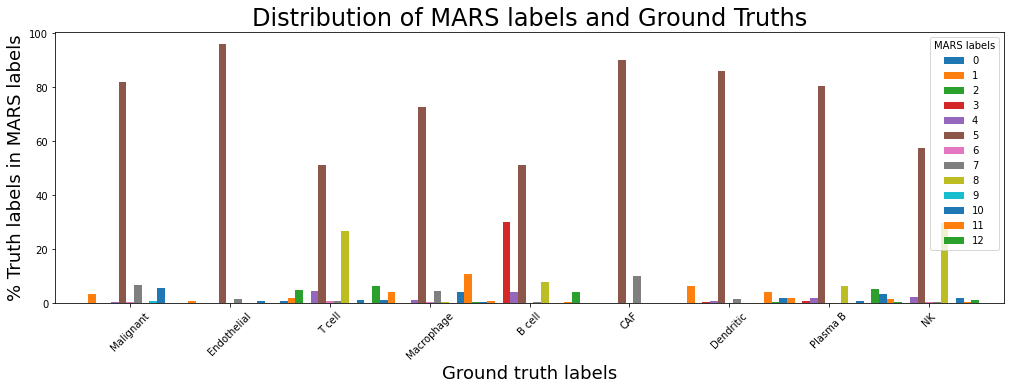

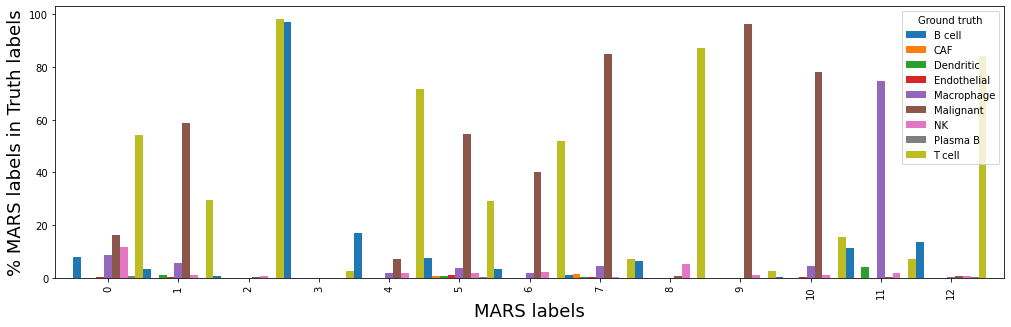

In [178]:
cell_type_assign(cvae_adata13, save=False)

... storing 'MARS_labels' as categorical
... storing 'label_name' as categorical


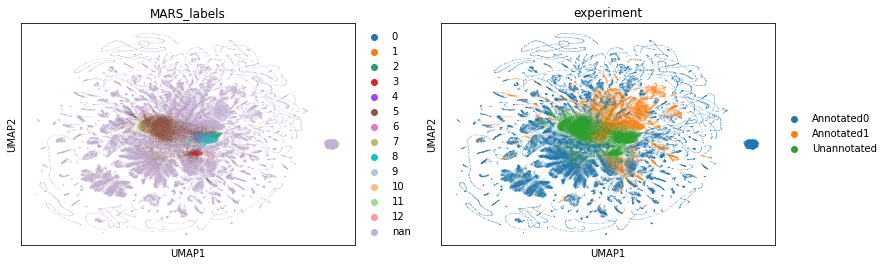

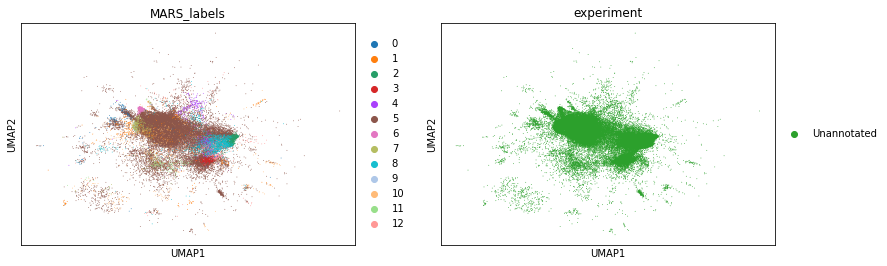

In [179]:
MARS_latent_umap(cvae_adata13, plot_gene_list = ['MARS_labels','experiment'], save=False)

#### Annotated: Maarten's colon set + MIT scRNA , Unannotated: scATAC 

In [30]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  
                                  multi_data.var_names, 
                                  return_indices=True)
gene_intersection = np.intersect1d(xy, mit_data.var_names)


# Get the indices for all three datasets
_, _, mit_ind = np.intersect1d(gene_intersection,  mit_data.var_names, return_indices=True)
_, _, atac_ind = np.intersect1d(gene_intersection,  scatac.var_names, return_indices=True)
_, _, multi_ind = np.intersect1d(gene_intersection,  multi_data.var_names, return_indices=True)


In [31]:
# Colon
rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'
rna_y['name'] = 0

# MIT
mit_y = mit_data.obs[['new_dbscan','annotated_celltype']]
mit_y.columns=['dbscan','annotated_celltype']
mit_y = mit_y.copy()
mit_y['omic'] = 'RNA'
mit_y['name'] = 1

# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'
atac_y['name'] = 2

common_y = rna_y.append(mit_y)
common_y = common_y.append(atac_y)
common_y = common_y.copy()

common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

In [32]:
common_y

dbscan annotated_celltype  omic  name  \
N10.EpiA.AAACGCACACAGCT          9          CD8+ IELs   RNA     0   
N10.EpiA.AAACGCTGGTTCGA          9          CD8+ IELs   RNA     0   
N10.EpiA.AAAGTTTGCCTAAG          9          CD8+ IELs   RNA     0   
N10.EpiA.AAATCTGAGGTCTA         10            CD8+ LP   RNA     0   
N10.EpiA.AACCTACTAGTTCG          9          CD8+ IELs   RNA     0   
...                            ...                ...   ...   ...   
pt509_2_TTTGTGTCATCATCGA-1       5             B cell  ATAC     2   
pt509_2_TTTGTGTGTAACGGCA-1       3             T cell  ATAC     2   
pt509_2_TTTGTGTGTAGCAGGT-1       3             T cell  ATAC     2   
pt509_2_TTTGTGTGTTAGGAAT-1       5             B cell  ATAC     2   
pt509_2_TTTGTGTTCTCGGCGA-1       3             T cell  ATAC     2   

                               annotation  
N10.EpiA.AAACGCACACAGCT     CD8+ IELs_RNA  
N10.EpiA.AAACGCTGGTTCGA     CD8+ IELs_RNA  
N10.EpiA.AAAGTTTGCCTAAG     CD8+ IELs_RNA  
N10.EpiA.AAATCTGAGGTCTA       CD8+ LP_RNA  
N10.EpiA.AACCTACTAGTTCG     CD8+ IELs_RNA  
...                                   ...  
pt509_2_TTTGTGTCATCATCGA-1    B cell_ATAC  
pt509_2_TTTGTGTGTAACGGCA-1    T cell_ATAC  
pt509_2_TTTGTGTGTAGCAGGT-1    T cell_ATAC  
pt509_2_TTTGTGTGTTAGGAAT-1    B cell_ATAC  
pt509_2_TTTGTGTTCTCGGCGA-1    T cell_ATAC  

[155796 rows x 5 columns]

In [33]:
raw_rna = multi_data.X[:,multi_ind]
raw_mit = mit_data.X[:,mit_ind]
raw_atac = scatac.X[:,atac_ind]

In [34]:
common_matrix = np.concatenate((raw_rna, raw_mit, raw_atac), axis=0)

In [35]:
label = torch.as_tensor (common_y['name'].values)
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 3)

In [36]:
cvae_annotated1 = ExperimentDataset(raw_rna, 
                                   multi_data.obs.index, 
                                   gene_intersection, 
                                   one_hot_label[np.where(common_y.name==0)[0]], 
                                   rna_y['dbscan'])

cvae_annotated2 = ExperimentDataset(raw_mit, 
                                     mit_data.obs.index, 
                                     gene_intersection, 
                                     one_hot_label[np.where(common_y.name==1)[0]], 
                                     mit_y['dbscan'])

cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     gene_intersection, 
                                     one_hot_label[np.where(common_y.name==2)[0]], 
                                     atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(common_matrix, 
                                  multi_data.obs.index.append(mit_data.obs.index).append(scatac.obs.index),
                                  gene_intersection,
                                  one_hot_label )

n_clusters= 11

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device




== Dataset: Found 65751 items 
== Dataset: Found 29 classes
== Dataset: Found 46089 items 
== Dataset: Found 9 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


#### CVAE Learning rate 1e-3, tau = 1e-3, lambda_kl=1e-2, n_clusters = 13

In [38]:
params.pretrain_batch = 256
params.epochs = 30
n_clusters= 13
params.epochs_pretrain = 50
params.learning_rate = 1e-3
tau = 1e-3 ##0.2


cvae_mars13 = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated1, cvae_annotated2], 
                      cvae_unannotated, cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = gene_intersection.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 3)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata13, cvae_landmarks13, cvae_scores13, cvae_training_history13, cvae_latent_tracker13, cvae_pretrain_latent13 , cave_pretrain_loss13 = cvae_mars13.train(evaluation_mode=True,save_all_embeddings=True)



Pretraining..
Pretraining Epoch 0, Loss: 93.18701171875
Time:  5.338788270950317
Pretraining Epoch 1, Loss: 121.25894927978516
Time:  9.40057921409607
Pretraining Epoch 2, Loss: 92.05135345458984
Time:  7.8790905475616455
Pretraining Epoch 3, Loss: 79.57518005371094
Time:  5.8560709953308105
Pretraining Epoch 4, Loss: 70.67942810058594
Time:  5.821857690811157
Pretraining Epoch 5, Loss: 71.3475570678711
Time:  5.596203088760376
Pretraining Epoch 6, Loss: 65.13386535644531
Time:  6.389910459518433
Pretraining Epoch 7, Loss: 61.828338623046875
Time:  6.414090871810913
Pretraining Epoch 8, Loss: 51.80044937133789
Time:  5.569572448730469
Pretraining Epoch 9, Loss: 86.53623962402344
Time:  5.501507043838501
Pretraining Epoch 10, Loss: 86.0371322631836
Time:  5.483912467956543
Pretraining Epoch 11, Loss: 98.12834930419922
Time:  5.888410568237305
Pretraining Epoch 12, Loss: 81.71197509765625
Time:  5.871973991394043
Pretraining Epoch 13, Loss: 73.87982940673828
Time:  5.936964750289917
Pret

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [154]:
cvae_scores13

{'precision': 0.34023269898037856,
 'nmi': 0.17824109842451577,
 'adj_rand': 0.11440420936091221,
 'recall': 0.21430631221929378,
 'f1_score': 0.2280490030642729,
 'adj_mi': 0.1776155783471113,
 'accuracy': 0.47338247338247336}

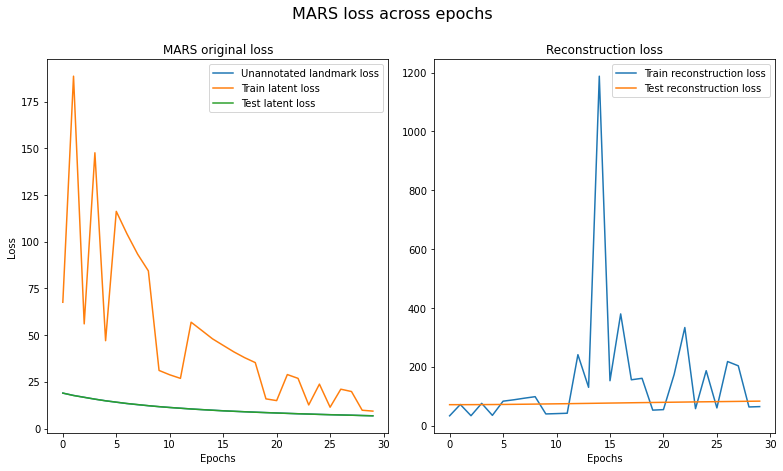

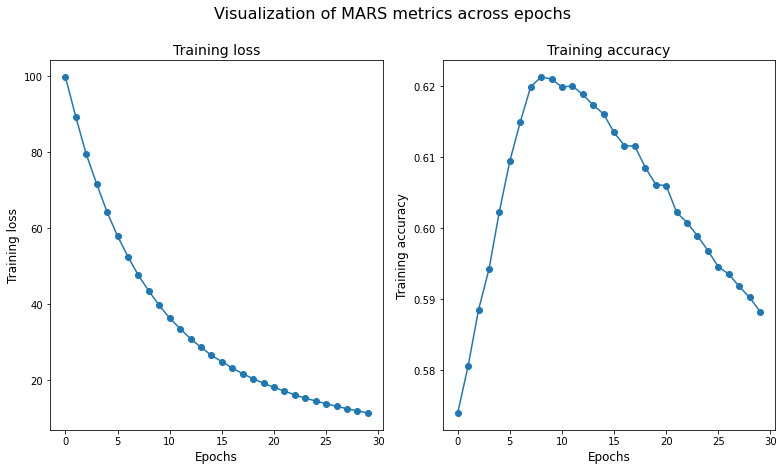

In [155]:
MARS_loss_tracker (cvae_training_history13, save = False)
MARS_history (cvae_training_history13, save = False)

... storing 'MARS_labels' as categorical
... storing 'label_name' as categorical


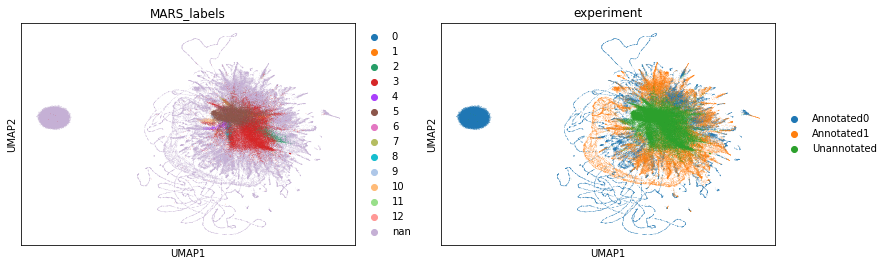

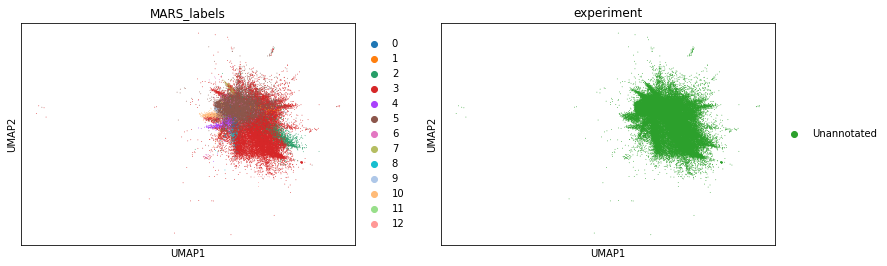

In [41]:
MARS_latent_umap(cvae_adata13, plot_gene_list = ['MARS_labels','experiment'], save=False)

... storing 'MARS_labels' as categorical


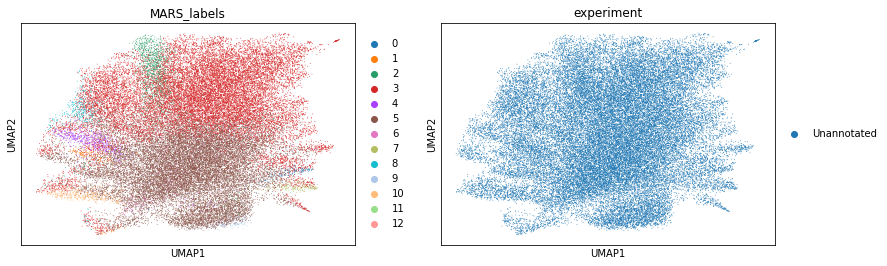

In [39]:
MARS_latent_umap_unanno(cvae_adata13, plot_gene_list = ['MARS_labels','experiment'], save=False)

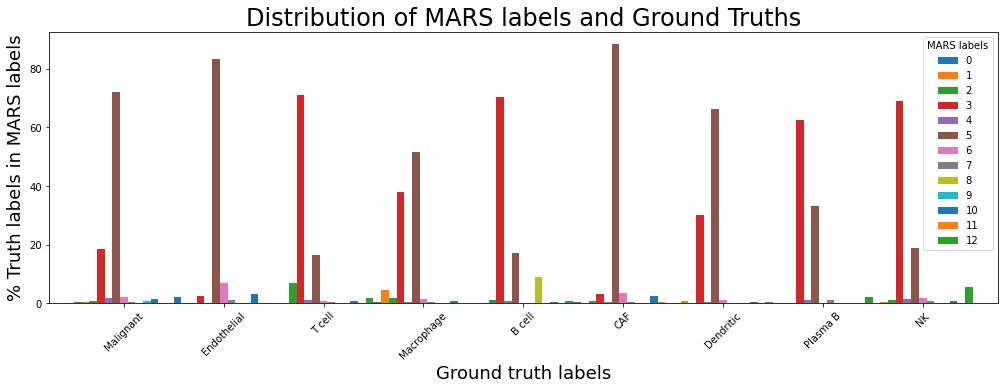

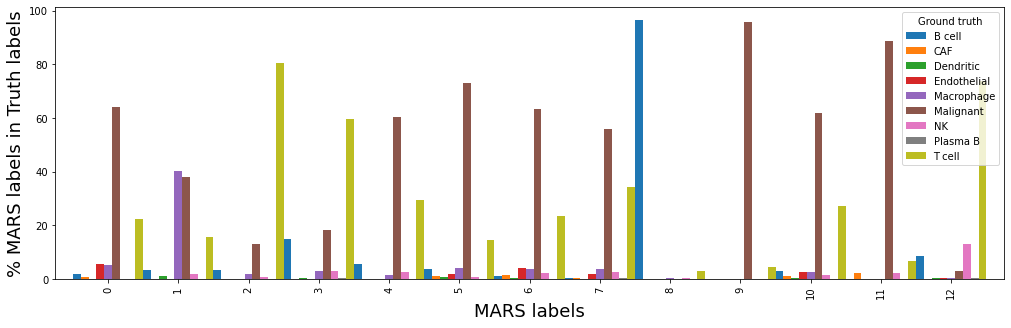

In [40]:
cell_type_assign(cvae_adata13, save=False)

In [158]:
Counter(cvae_adata13.obs.MARS_labels)

Counter({nan: 111629,
         9: 20791,
         4: 1296,
         7: 419,
         3: 336,
         0: 2599,
         1: 9477,
         11: 2869,
         5: 373,
         6: 2858,
         12: 1043,
         2: 582,
         8: 600,
         10: 713})

#### CVAE Learning rate 1e-3, tau = 1e-3, lambda_kl=1e-2

In [137]:
params.epochs_pretrain = 30
params.learning_rate = 1e-3
tau = tau=1e-3 ##0.2


cvae_mars1 = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated1, cvae_annotated2], 
                      cvae_unannotated, cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = gene_intersection.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 3)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata1, cvae_landmarks1, cvae_scores1, cvae_training_history1, cvae_latent_tracker1, cvae_pretrain_latent1 , cave_pretrain_loss1 = cvae_mars1.train(evaluation_mode=True,save_all_embeddings=True)





Pretraining..
Pretraining Epoch 0, Loss: 132.0140838623047
Time:  7.419296026229858
Pretraining Epoch 1, Loss: 147.11184692382812
Time:  8.110123634338379
Pretraining Epoch 2, Loss: 113.75037384033203
Time:  8.448358058929443
Pretraining Epoch 3, Loss: 71.87532806396484
Time:  7.758376598358154
Pretraining Epoch 4, Loss: 89.99925231933594
Time:  7.4683990478515625
Pretraining Epoch 5, Loss: 64.59825134277344
Time:  8.510440111160278
Pretraining Epoch 6, Loss: 61.385520935058594
Time:  7.972348213195801
Pretraining Epoch 7, Loss: 91.74232482910156
Time:  7.726877450942993
Pretraining Epoch 8, Loss: 45.7804069519043
Time:  8.060165405273438
Pretraining Epoch 9, Loss: 83.2784194946289
Time:  10.25351333618164
Pretraining Epoch 10, Loss: 126.71576690673828
Time:  7.7550153732299805
Pretraining Epoch 11, Loss: 63.88088607788086
Time:  8.05220365524292
Pretraining Epoch 12, Loss: 52.11333465576172
Time:  10.91869330406189
Pretraining Epoch 13, Loss: 42.2108154296875
Time:  9.19780969619751
P

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [138]:
cvae_scores1

{'precision': 0.3449384947426999,
 'nmi': 0.21223421274398133,
 'adj_rand': 0.2093239688914945,
 'recall': 0.22108369443655893,
 'f1_score': 0.2429667824299323,
 'adj_mi': 0.2116749095122658,
 'accuracy': 0.5872463372463372}

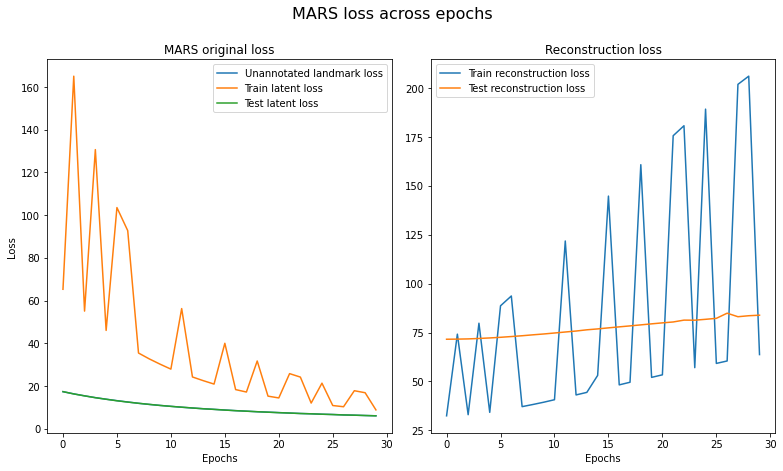

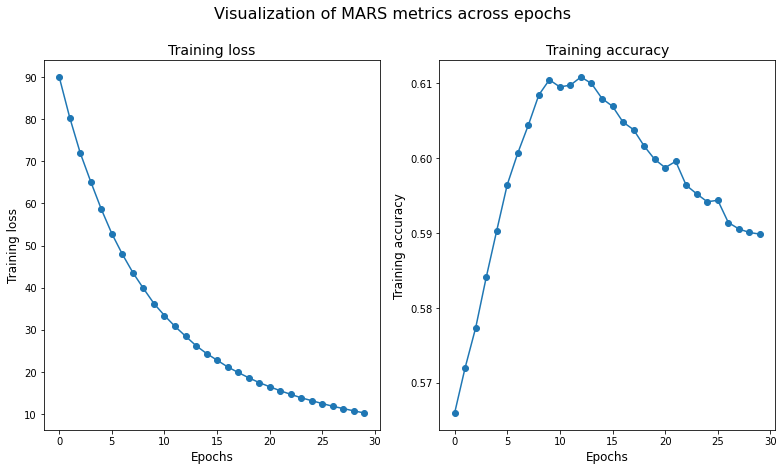

In [139]:
MARS_loss_tracker (cvae_training_history1, save = False)
MARS_history (cvae_training_history1, save = False)

... storing 'label_name' as categorical


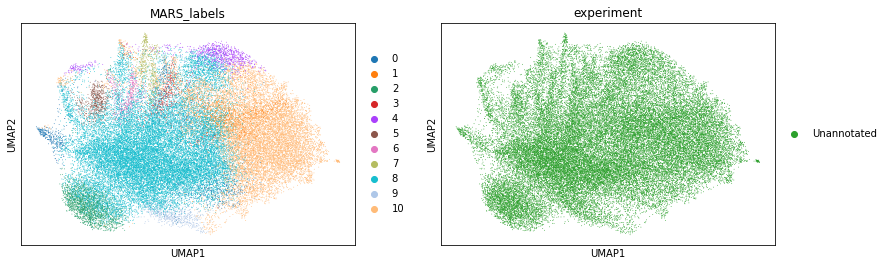

In [152]:
MARS_latent_umap_unanno(cvae_adata1, plot_gene_list = ['MARS_labels','experiment'], save=False)

... storing 'MARS_labels' as categorical


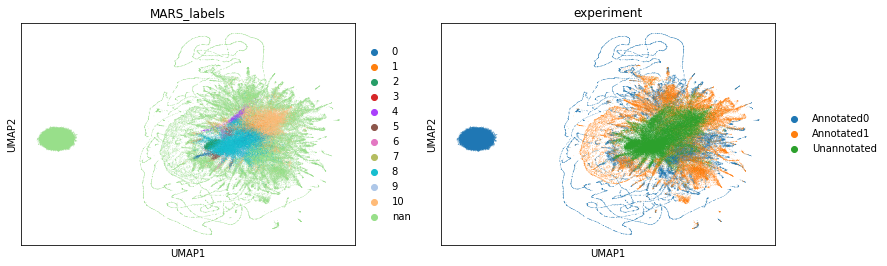

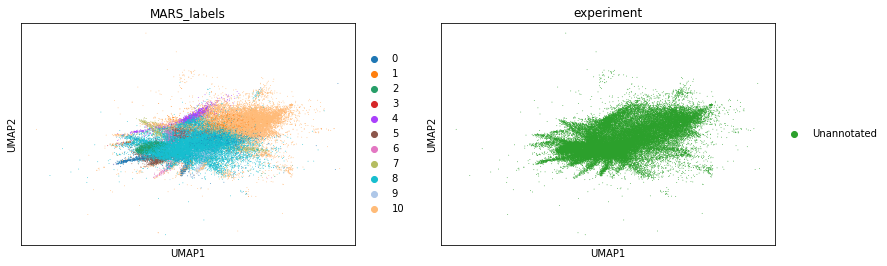

In [140]:
MARS_latent_umap(cvae_adata1, plot_gene_list = ['MARS_labels','experiment'], save=False)

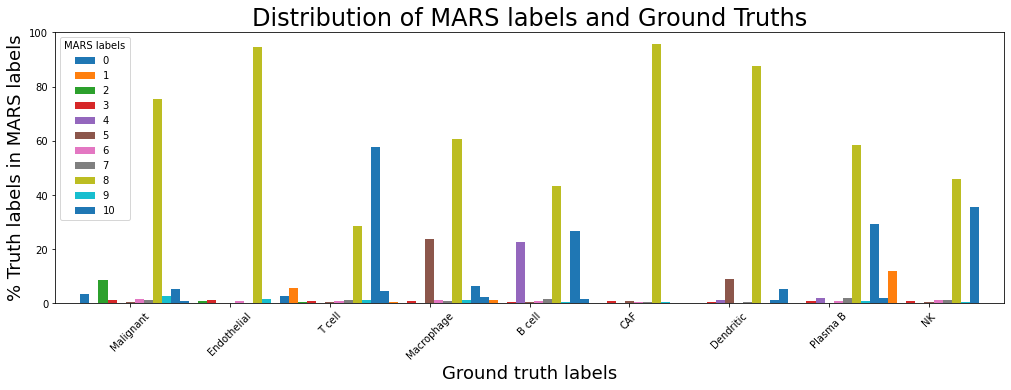

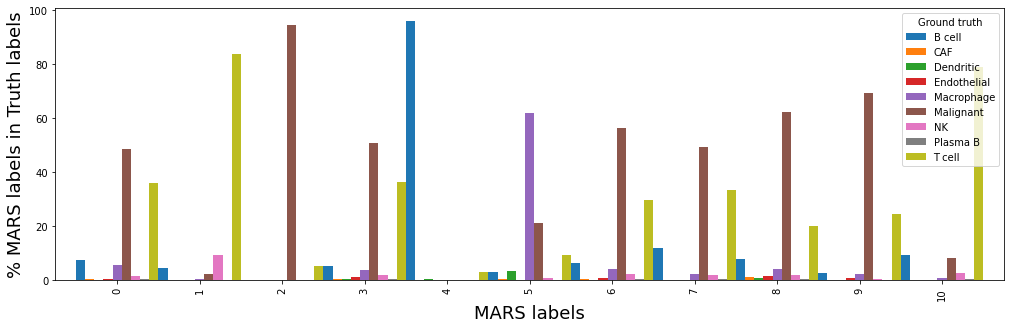

In [141]:
cell_type_assign(cvae_adata1, save=False)

In [126]:
labeled_name=[]
tmp = [labeled_name.append(k) for k in name2num.keys()]
tmp = [labeled_name.append(k) for k in multi_nametonum.keys()]

In [127]:
Counter(cvae_adata1.obs.MARS_labels)

Counter({'nan': 111629,
         '0': 1544,
         '2': 19040,
         '1': 5408,
         '3': 1871,
         '5': 1344,
         '4': 1501,
         '8': 9485,
         '10': 1773,
         '7': 668,
         '6': 842,
         '9': 480})

### cell type naming was only done on a subset of cells that have a mangeable number of cells.

In [130]:
subset  = cvae_adata[(cvae_adata.obs['experiment']=='Annotated0')|
                     (cvae_adata.obs['experiment']=='Annotated1')|
                     (cvae_adata.obs['MARS_labels']=='0')|
                     (cvae_adata.obs['MARS_labels']=='1')|
                     (cvae_adata.obs['MARS_labels']=='10')|
                     (cvae_adata.obs['MARS_labels']=='4')]
name = cvae_mars1.name_cell_types(subset , 
                                 cvae_landmarks1, 
                                 labeled_name,
                                 umap_reduce_dim=False
                                )

In [132]:
# name = cvae_mars1.name_cell_types(subset , 
#                                  cvae_landmarks1, 
#                                  labeled_name,
#                                  umap_reduce_dim=False
#                                 )

### CVAE Learning rate 1e-3, tau =0.2, lambda_kl=1e-2

In [142]:
params.epochs_pretrain = 30
tau=0.2

cvae_mars = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated1, cvae_annotated2], 
                      cvae_unannotated, cvae_pretrain, 
                      val_split=1.0, 
                      hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=tau,
                      latent_dim = 50, 
                      n_feature = gene_intersection.shape[0],
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, 
                      batch_shape = 3)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata, cvae_landmarks, cvae_scores, cvae_training_history, cvae_latent_tracker, cvae_pretrain_latent , cave_pretrain_loss = cvae_mars.train(evaluation_mode=True,save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 81.7066879272461
Time:  8.46729302406311
Pretraining Epoch 1, Loss: 164.4750213623047
Time:  11.254549980163574
Pretraining Epoch 2, Loss: 62.94902420043945
Time:  9.518010139465332
Pretraining Epoch 3, Loss: 150.8341522216797
Time:  9.261059999465942
Pretraining Epoch 4, Loss: 96.9740982055664
Time:  17.467663049697876
Pretraining Epoch 5, Loss: 110.21218872070312
Time:  22.47652816772461
Pretraining Epoch 6, Loss: 71.62366485595703
Time:  16.73601984977722
Pretraining Epoch 7, Loss: 75.00249481201172
Time:  20.166170120239258
Pretraining Epoch 8, Loss: 60.2452507019043
Time:  16.611056089401245
Pretraining Epoch 9, Loss: 91.17323303222656
Time:  11.229981422424316
Pretraining Epoch 10, Loss: 88.60592651367188
Time:  8.232099056243896
Pretraining Epoch 11, Loss: 53.77669143676758
Time:  8.491408824920654
Pretraining Epoch 12, Loss: 59.96450424194336
Time:  9.749642610549927
Pretraining Epoch 13, Loss: 156.20489501953125
Time:  8.742839097976685

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [143]:
cvae_scores

{'precision': 0.36085456089335993,
 'nmi': 0.22703209981432246,
 'adj_rand': 0.21753059810898603,
 'recall': 0.23819258622577621,
 'f1_score': 0.25485583978589266,
 'adj_mi': 0.22649554370930058,
 'accuracy': 0.5814678314678314}

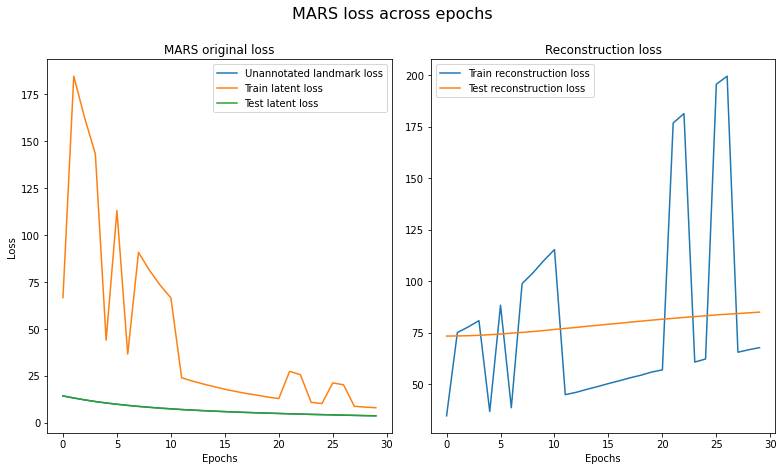

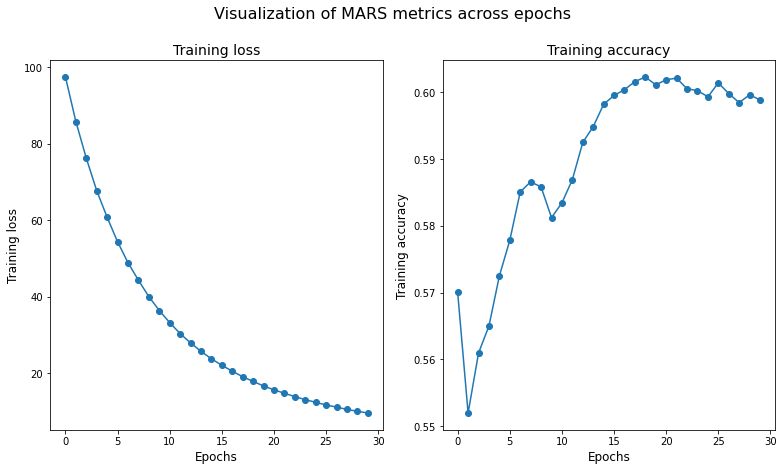

In [144]:
MARS_loss_tracker (cvae_training_history, save = False)
MARS_history (cvae_training_history, save = False)

... storing 'MARS_labels' as categorical


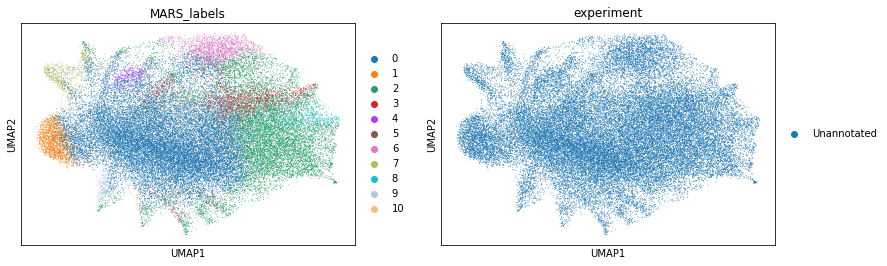

In [150]:
MARS_latent_umap_unanno(cvae_adata, plot_gene_list = ['MARS_labels','experiment'], save=False)

... storing 'MARS_labels' as categorical


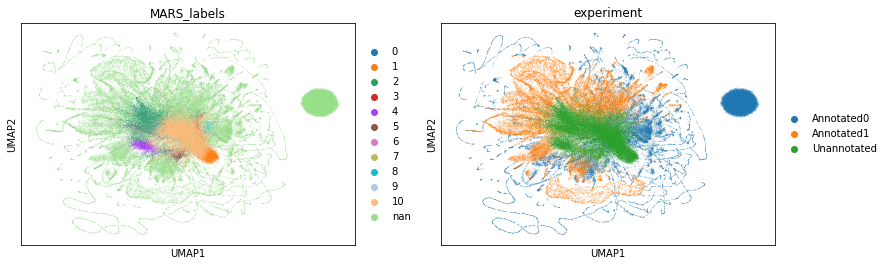

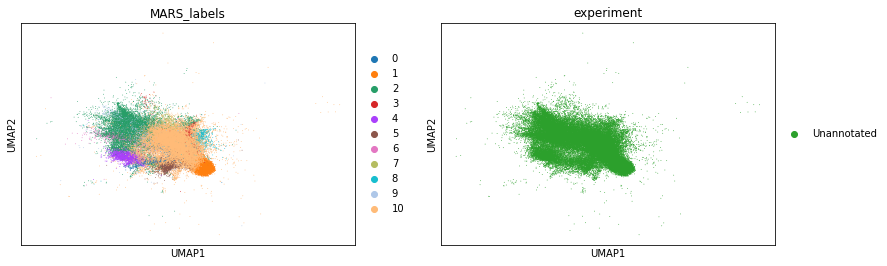

In [96]:
MARS_latent_umap(cvae_adata, plot_gene_list = ['MARS_labels','experiment'], save=False)

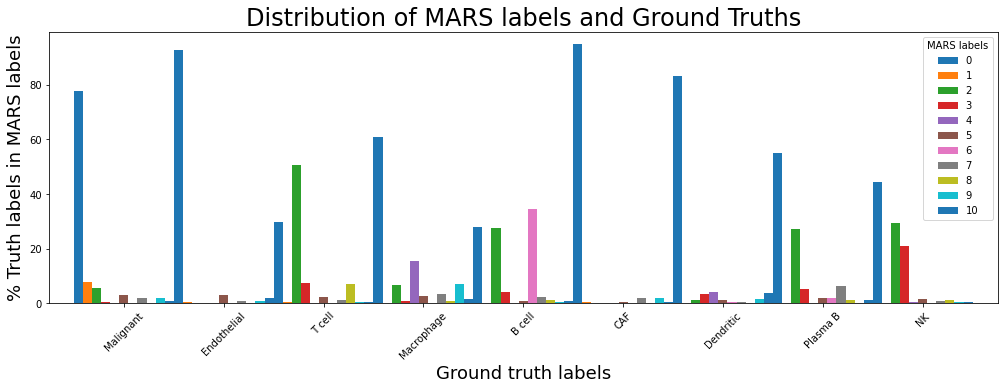

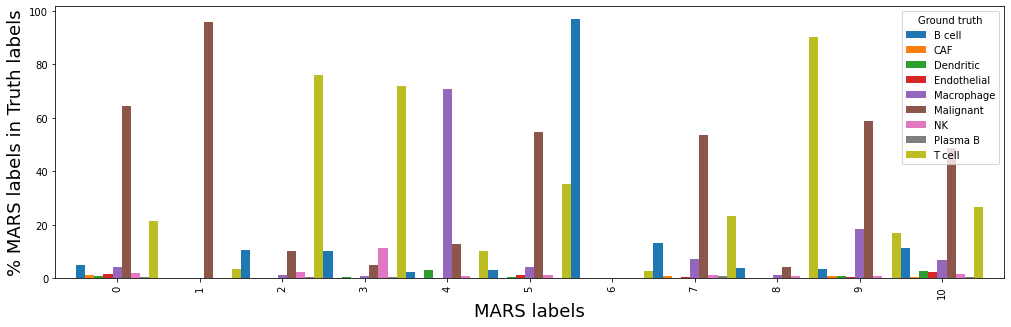

In [151]:
cell_type_assign(cvae_adata, save=False)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


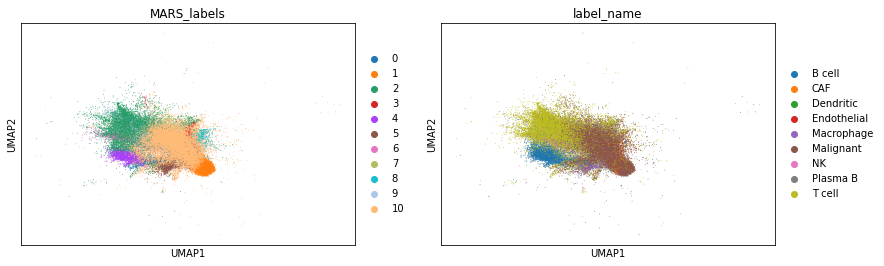

In [98]:
sc.pl.umap(cvae_adata[cvae_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=2)

In [99]:
labeled_name=[]
tmp = [labeled_name.append(k) for k in name2num.keys()]
tmp = [labeled_name.append(k) for k in multi_nametonum.keys()]

In [100]:
labeled_name

['Malignant',
 'Endothelial',
 'T cell',
 'Macrophage',
 'B cell',
 'CAF',
 'Dendritic',
 'Plasma B',
 'NK',
 'CD8+ T cell',
 'CD4+ T cell',
 'NKs',
 'B cell',
 'Mast',
 'Monocyte',
 'Fibroblasts',
 'Endothelial cells',
 'Glia']

In [111]:
Counter(cvae_adata.obs.MARS_labels)

Counter({'nan': 111629,
         '10': 23289,
         '9': 1741,
         '5': 1154,
         '2': 10172,
         '1': 2825,
         '4': 2366,
         '6': 649,
         '3': 375,
         '8': 571,
         '0': 503,
         '7': 311})

In [119]:
subset  = cvae_adata[(cvae_adata.obs['experiment']=='Annotated0')|
                     (cvae_adata.obs['experiment']=='Annotated1')|
                     (cvae_adata.obs['MARS_labels']=='0')|
                     (cvae_adata.obs['MARS_labels']=='1')|
                     (cvae_adata.obs['MARS_labels']=='3')|
                     (cvae_adata.obs['MARS_labels']=='4')]

In [120]:
subset.obs

truth_labels MARS_labels  \
N20.LPA.GCCTACACCTGAGT-Annotated0                    12         nan   
N20.LPB.TTGGAGACCTCATT-Annotated0                    10         nan   
N26.LPA.CTCTAATAGCTAGCCC-Annotated0                  13         nan   
N23.LPB.TGACGGCTCGTGGACC-Annotated0                  12         nan   
N23.EpiB.AACTCAGTCTTTAGTC-Annotated0                 12         nan   
...                                                 ...         ...   
pt509_post_GAACGTTTCCGAGGAA-1-Unannotated             1           1   
pt856_B_GCCCGAAAGAACCCGA-1-Unannotated                1           3   
pt1009_AGGCCTGGTCATTGCA-1-Unannotated                 5           4   
pt509_post_TAGCCCTGTCACCCGA-1-Unannotated             1           1   
pt509_2_ATTGTGGGTATATGGA-1-Unannotated                5           4   

                                            experiment label_name  
N20.LPA.GCCTACACCTGAGT-Annotated0           Annotated0        NaN  
N20.LPB.TTGGAGACCTCATT-Annotated0           Annotated0        NaN  
N26.LPA.CTCTAATAGCTAGCCC-Annotated0         Annotated0        NaN  
N23.LPB.TGACGGCTCGTGGACC-Annotated0         Annotated0        NaN  
N23.EpiB.AACTCAGTCTTTAGTC-Annotated0        Annotated0        NaN  
...                                                ...        ...  
pt509_post_GAACGTTTCCGAGGAA-1-Unannotated  Unannotated  Malignant  
pt856_B_GCCCGAAAGAACCCGA-1-Unannotated     Unannotated  Malignant  
pt1009_AGGCCTGGTCATTGCA-1-Unannotated      Unannotated     B cell  
pt509_post_TAGCCCTGTCACCCGA-1-Unannotated  Unannotated  Malignant  
pt509_2_ATTGTGGGTATATGGA-1-Unannotated     Unannotated     B cell  

[117698 rows x 4 columns]

In [121]:
name = cvae_mars.name_cell_types(subset , 
                                 cvae_landmarks, 
                                 labeled_name,
                                 umap_reduce_dim=False
                                )


Cluster label: 0
Malignant: 0.03200434468253443
Mast: 0.14669903490784597
CD8+ T cell: 0.1737301196158506
CD4+ T cell: 0.28777784201409906
B cell: 0.3388063894038857

Cluster label: 1
Mast: 0.007810827731162385
CD8+ T cell: 0.06367815424006541
Fibroblasts: 0.18067306527617533
B cell: 0.2064110640460757
CD4+ T cell: 0.5403919694061652

Cluster label: 3
Malignant: 0.07697412922358675
CD8+ T cell: 0.14105454984633328
B cell: 0.17766665046168145
Mast: 0.27009648942022707
CD4+ T cell: 0.32235201907317684

Cluster label: 4
Mast: 0.017612478130781282
CD4+ T cell: 0.07364354639112046
CD8+ T cell: 0.07710509457624098
B cell: 0.12046391432452722
B cell: 0.6890245264983369
